Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import rasterio
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold
import joblib
import optuna
import matplotlib.pyplot as plt 
import shap

# Load data from xls file
data = pd.read_excel("MP_S2.xlsx")

# Separate features and target
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values



Building model and optimizing the hyperparameters 

In [2]:
# Define objective function for Optuna optimization
def objective(trial):
    # Set hyperparameters to optimize
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50,50), (100,50), (20,60,10), 
                                                                          (5,10,20), (100, 5, 20), (10, 10), (10, 15), (20,30)
                                                                         ,(25, 30), (40, 10, 20), (100, 50, 30), (200, 20, 10), 
                                                                          (30, 20), (150, 150)])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
    alpha = trial.suggest_loguniform('alpha', 1e-4, 1e-1)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    batch_size = trial.suggest_int('batch_size', 32, 128)

    # Initialize ANN model with hyperparameters
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                         activation=activation,
                         solver=solver,
                         alpha=alpha,
                         learning_rate=learning_rate,
                         max_iter=max_iter, batch_size=batch_size,
                         random_state=42)

    # Set kfold for cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Calculate cross-validation score using R2 as evaluation metric
    score = cross_val_score(model, X, y, cv=kfold, scoring='r2')

    # Return mean of R2 scores as objective value
    return score.mean()

# Run Optuna optimization to find best hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, show_progress_bar=True)

# Print best hyperparameters found by Optuna
print("Best hyperparameters: ", study.best_params)


[I 2023-03-03 14:10:48,196] A new study created in memory with name: no-name-088d8a7f-1f1a-4a57-96f4-bad8870585ad
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:10:53,965] Trial 0 finished with value: -0.9017666456597044 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.0008228013575556223, 'learning_rate': 'adaptive', 'max_iter': 965, 'batch_size': 76}. Best is trial 0 with value: -0.9017666456597044.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (661) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (661) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:10:56,160] Trial 1 finished with value: -1.2571179327656783 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.010304179753638253, 'learning_rate': 'invscaling', 'max_iter': 661, 'batch_size': 111}. Best is trial 0 with value: -0.9017666456597044.
[I 2023-03-03 14:10:56,675] Trial 2 finished with value: -0.22905628652112248 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.004092991649738821, 'learning_rate': 'adaptive', 'max_iter': 661, 'batch_size': 128}. Best is trial 2 with value: -0.22905628652112248.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:10:57,206] Trial 3 finished with value: -0.890204397670216 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.0030944462538218804, 'learning_rate': 'adaptive', 'max_iter': 287, 'batch_size': 84}. Best is trial 2 with value: -0.22905628652112248.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

[I 2023-03-03 14:10:58,930] Trial 4 finished with value: -0.7303334058952696 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.0001676921195921908, 'learning_rate': 'invscaling', 'max_iter': 584, 'batch_size': 81}. Best is trial 2 with value: -0.22905628652112248.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (614) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (614) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:10:59,828] Trial 5 finished with value: -0.25490209378174766 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.025209716494628685, 'learning_rate': 'invscaling', 'max_iter': 614, 'batch_size': 119}. Best is trial 2 with value: -0.22905628652112248.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int

[I 2023-03-03 14:11:00,106] Trial 6 finished with value: -0.04368831118667056 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.00019403073773751573, 'learning_rate': 'adaptive', 'max_iter': 272, 'batch_size': 97}. Best is trial 6 with value: -0.04368831118667056.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (755) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (755) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:11:01,604] Trial 7 finished with value: -0.07958427418765442 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.004970779361953855, 'learning_rate': 'adaptive', 'max_iter': 755, 'batch_size': 80}. Best is trial 6 with value: -0.04368831118667056.
[I 2023-03-03 14:11:01,913] Trial 8 finished with value: -0.03182958094423518 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.02118225861334868, 'learning_rate': 'adaptive', 'max_iter': 834, 'batch_size': 34}. Best is trial 8 with value: -0.03182958094423518.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:02,650] Trial 9 finished with value: -0.01449526822389353 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0003452556771350549, 'learning_rate': 'adaptive', 'max_iter': 910, 'batch_size': 62}. Best is trial 9 with value: -0.01449526822389353.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:03,838] Trial 10 finished with value: -0.018039433728496458 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07802116006198788, 'learning_rate': 'constant', 'max_iter': 992, 'batch_size': 49}. Best is trial 9 with value: -0.01449526822389353.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:04,657] Trial 11 finished with value: -0.006950585236690343 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05665226101496658, 'learning_rate': 'constant', 'max_iter': 986, 'batch_size': 52}. Best is trial 11 with value: -0.006950585236690343.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:05,421] Trial 12 finished with value: -0.006661566859412704 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0007976278333798039, 'learning_rate': 'constant', 'max_iter': 863, 'batch_size': 58}. Best is trial 12 with value: -0.006661566859412704.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:06,276] Trial 13 finished with value: -0.008020053521946702 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0010124564251895146, 'learning_rate': 'constant', 'max_iter': 448, 'batch_size': 56}. Best is trial 12 with value: -0.006661566859412704.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:07,021] Trial 14 finished with value: -0.004976260473678273 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.049194986855945595, 'learning_rate': 'constant', 'max_iter': 795, 'batch_size': 32}. Best is trial 14 with value: -0.004976260473678273.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:07,523] Trial 15 finished with value: -0.013882354668104124 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0017033872242915066, 'learning_rate': 'constant', 'max_iter': 795, 'batch_size': 36}. Best is trial 14 with value: -0.004976260473678273.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:08,311] Trial 16 finished with value: -0.0357757986184634 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0004910765582614673, 'learning_rate': 'constant', 'max_iter': 445, 'batch_size': 67}. Best is trial 14 with value: -0.004976260473678273.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:09,937] Trial 17 finished with value: -0.02791488734851333 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0018097885179469773, 'learning_rate': 'constant', 'max_iter': 751, 'batch_size': 42}. Best is trial 14 with value: -0.004976260473678273.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (851) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (851) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (851) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (851) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:11:11,890] Trial 18 finished with value: -0.016258962653171373 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09418385830673565, 'learning_rate': 'constant', 'max_iter': 851, 'batch_size': 43}. Best is trial 14 with value: -0.004976260473678273.
[I 2023-03-03 14:11:12,054] Trial 19 finished with value: -0.1394478392489015 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.00859170843896109, 'learning_rate': 'constant', 'max_iter': 160, 'batch_size': 67}. Best is trial 14 with value: -0.004976260473678273.
[I 2023-03-03 14:11:13,192] Trial 20 finished with value: -0.012139712368740474 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03773373313692823, 'learning_rate': 'constant', 'max_iter': 504, 'batch_size': 32}. Best is trial 14 with value: -0.004976260473678273.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:14,094] Trial 21 finished with value: -0.009559197393193353 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.034745519483368764, 'learning_rate': 'constant', 'max_iter': 907, 'batch_size': 53}. Best is trial 14 with value: -0.004976260473678273.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:15,499] Trial 22 finished with value: -0.021920311121057322 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09586567237661046, 'learning_rate': 'constant', 'max_iter': 900, 'batch_size': 45}. Best is trial 14 with value: -0.004976260473678273.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:16,235] Trial 23 finished with value: -0.005900104706392129 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.051856033737861774, 'learning_rate': 'constant', 'max_iter': 997, 'batch_size': 57}. Best is trial 14 with value: -0.004976260473678273.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:17,811] Trial 24 finished with value: -0.01638783022811956 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.015981509386248652, 'learning_rate': 'constant', 'max_iter': 710, 'batch_size': 90}. Best is trial 14 with value: -0.004976260473678273.
[I 2023-03-03 14:11:18,643] Trial 25 finished with value: -0.009843581505962162 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0516996966181864, 'learning_rate': 'constant', 'max_iter': 875, 'batch_size': 61}. Best is trial 14 with value: -0.004976260473678273.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:20,251] Trial 26 finished with value: -0.021190905489967316 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.015251029680448707, 'learning_rate': 'invscaling', 'max_iter': 799, 'batch_size': 72}. Best is trial 14 with value: -0.004976260473678273.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

[I 2023-03-03 14:11:32,129] Trial 27 finished with value: -1.8607029689233152 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.03131051528640274, 'learning_rate': 'constant', 'max_iter': 954, 'batch_size': 60}. Best is trial 14 with value: -0.004976260473678273.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (704) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1

[I 2023-03-03 14:11:33,530] Trial 28 finished with value: -0.03479321322238778 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.05271676191659026, 'learning_rate': 'constant', 'max_iter': 704, 'batch_size': 98}. Best is trial 14 with value: -0.004976260473678273.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (968) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (968) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:11:35,333] Trial 29 finished with value: -0.04233464474578348 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.008441559855134674, 'learning_rate': 'constant', 'max_iter': 968, 'batch_size': 73}. Best is trial 14 with value: -0.004976260473678273.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

[I 2023-03-03 14:11:37,479] Trial 30 finished with value: -1.0671709505128864 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.018446079323053623, 'learning_rate': 'invscaling', 'max_iter': 817, 'batch_size': 39}. Best is trial 14 with value: -0.004976260473678273.
[I 2023-03-03 14:11:38,651] Trial 31 finished with value: -0.018090553437825375 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05404080692071724, 'learning_rate': 'constant', 'max_iter': 996, 'batch_size': 49}. Best is trial 14 with value: -0.004976260473678273.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:39,377] Trial 32 finished with value: -0.0027675171650330286 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06182612722101745, 'learning_rate': 'constant', 'max_iter': 928, 'batch_size': 52}. Best is trial 32 with value: -0.0027675171650330286.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:39,995] Trial 33 finished with value: -0.008920679768050466 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03578240486066373, 'learning_rate': 'constant', 'max_iter': 940, 'batch_size': 57}. Best is trial 32 with value: -0.0027675171650330286.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:40,759] Trial 34 finished with value: -0.0035113964306054735 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.013076539515291067, 'learning_rate': 'constant', 'max_iter': 879, 'batch_size': 46}. Best is trial 32 with value: -0.0027675171650330286.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:45,120] Trial 35 finished with value: -0.6974319880208323 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.013706610878499817, 'learning_rate': 'constant', 'max_iter': 932, 'batch_size': 47}. Best is trial 32 with value: -0.0027675171650330286.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (645) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of 

[I 2023-03-03 14:11:46,324] Trial 36 finished with value: -0.024180893185870002 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02453254747105592, 'learning_rate': 'invscaling', 'max_iter': 645, 'batch_size': 38}. Best is trial 32 with value: -0.0027675171650330286.
[I 2023-03-03 14:11:46,986] Trial 37 finished with value: -0.007268968815376109 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07174462243776257, 'learning_rate': 'constant', 'max_iter': 758, 'batch_size': 41}. Best is trial 32 with value: -0.0027675171650330286.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:48,617] Trial 38 finished with value: -0.8450150305359504 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.025250439414090237, 'learning_rate': 'invscaling', 'max_iter': 548, 'batch_size': 65}. Best is trial 32 with value: -0.0027675171650330286.
[I 2023-03-03 14:11:48,929] Trial 39 finished with value: -0.05027241663271069 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01162595188659569, 'learning_rate': 'adaptive', 'max_iter': 875, 'batch_size': 52}. Best is trial 32 with value: -0.0027675171650330286.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:50,942] Trial 40 finished with value: -0.04421457170874481 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.04180164975108954, 'learning_rate': 'constant', 'max_iter': 699, 'batch_size': 32}. Best is trial 32 with value: -0.0027675171650330286.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:51,609] Trial 41 finished with value: -0.0001366584281148109 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07034051956075157, 'learning_rate': 'constant', 'max_iter': 846, 'batch_size': 56}. Best is trial 41 with value: -0.0001366584281148109.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:52,424] Trial 42 finished with value: 0.0014750842281494147 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07087140190203761, 'learning_rate': 'constant', 'max_iter': 827, 'batch_size': 47}. Best is trial 42 with value: 0.0014750842281494147.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:53,094] Trial 43 finished with value: -0.0064901877985189095 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0723285290387954, 'learning_rate': 'constant', 'max_iter': 816, 'batch_size': 38}. Best is trial 42 with value: 0.0014750842281494147.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:53,818] Trial 44 finished with value: -0.002693640267285602 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09993906284442382, 'learning_rate': 'adaptive', 'max_iter': 766, 'batch_size': 46}. Best is trial 42 with value: 0.0014750842281494147.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:54,565] Trial 45 finished with value: -0.002929692783908844 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07567103505383362, 'learning_rate': 'adaptive', 'max_iter': 754, 'batch_size': 46}. Best is trial 42 with value: 0.0014750842281494147.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:55,245] Trial 46 finished with value: -0.0031032230024049534 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09319834867715682, 'learning_rate': 'adaptive', 'max_iter': 750, 'batch_size': 52}. Best is trial 42 with value: 0.0014750842281494147.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:55,624] Trial 47 finished with value: -0.06699584920977428 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0694188734255672, 'learning_rate': 'adaptive', 'max_iter': 577, 'batch_size': 110}. Best is trial 42 with value: 0.0014750842281494147.
[I 2023-03-03 14:11:56,404] Trial 48 finished with value: 0.0038126761764164076 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06213784738537231, 'learning_rate': 'adaptive', 'max_iter': 644, 'batch_size': 49}. Best is trial 48 with value: 0.0038126761764164076.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:56,922] Trial 49 finished with value: -0.0076172301433780065 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09948608453181308, 'learning_rate': 'adaptive', 'max_iter': 652, 'batch_size': 63}. Best is trial 48 with value: 0.0038126761764164076.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:58,160] Trial 50 finished with value: -0.014028841561937223 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.028586517236125854, 'learning_rate': 'adaptive', 'max_iter': 678, 'batch_size': 70}. Best is trial 48 with value: 0.0038126761764164076.
[I 2023-03-03 14:11:58,952] Trial 51 finished with value: 0.003954004655804666 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0709249158020314, 'learning_rate': 'adaptive', 'max_iter': 771, 'batch_size': 49}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:11:59,652] Trial 52 finished with value: -0.0020614678573263713 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06262915873115397, 'learning_rate': 'adaptive', 'max_iter': 834, 'batch_size': 54}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:00,557] Trial 53 finished with value: -0.018868292207438953 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.045644672588629025, 'learning_rate': 'adaptive', 'max_iter': 614, 'batch_size': 55}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:01,225] Trial 54 finished with value: -0.005284088456779168 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06515942493912262, 'learning_rate': 'adaptive', 'max_iter': 779, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:12:02,031] Trial 55 finished with value: -0.001620820153929281 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.04070581385917527, 'learning_rate': 'adaptive', 'max_iter': 833, 'batch_size': 50}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:02,789] Trial 56 finished with value: -0.011779889361713657 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03853256187224823, 'learning_rate': 'adaptive', 'max_iter': 848, 'batch_size': 49}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:04,559] Trial 57 finished with value: -0.025711844289349826 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.04314581848158072, 'learning_rate': 'adaptive', 'max_iter': 838, 'batch_size': 42}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[I 2023-03-03 14:12:05,408] Trial 58 finished with value: -0.3017278723320948 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.022944899356813556, 'learning_rate': 'adaptive', 'max_iter': 719, 'batch_size': 58}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:05,643] Trial 59 finished with value: -0.04298802714275416 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.030860340122968122, 'learning_rate': 'adaptive', 'max_iter': 446, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:06,206] Trial 60 finished with value: -0.01636938174263729 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.060815406261771225, 'learning_rate': 'adaptive', 'max_iter': 315, 'batch_size': 49}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:08,163] Trial 61 finished with value: -0.03444682780356847 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08349701548954844, 'learning_rate': 'adaptive', 'max_iter': 774, 'batch_size': 43}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:12:08,832] Trial 62 finished with value: -0.0021384222940468377 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09939412285115495, 'learning_rate': 'adaptive', 'max_iter': 730, 'batch_size': 55}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:09,537] Trial 63 finished with value: -0.010701978363216047 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0765769114949159, 'learning_rate': 'adaptive', 'max_iter': 735, 'batch_size': 62}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:11,297] Trial 64 finished with value: -0.027671400430855763 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.04342922507790797, 'learning_rate': 'adaptive', 'max_iter': 813, 'batch_size': 128}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:12:12,194] Trial 65 finished with value: -0.008870955416276138 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05880197061111157, 'learning_rate': 'adaptive', 'max_iter': 678, 'batch_size': 55}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:14,938] Trial 66 finished with value: -0.03684670407573898 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.04878531802849857, 'learning_rate': 'adaptive', 'max_iter': 612, 'batch_size': 36}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:12:16,382] Trial 67 finished with value: -0.013099338475240873 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07835916034918479, 'learning_rate': 'adaptive', 'max_iter': 897, 'batch_size': 59}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:17,103] Trial 68 finished with value: -0.01475667117406081 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.030785824708185878, 'learning_rate': 'adaptive', 'max_iter': 848, 'batch_size': 65}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:18,068] Trial 69 finished with value: -0.029502495195583723 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05997915933180192, 'learning_rate': 'adaptive', 'max_iter': 791, 'batch_size': 50}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:18,580] Trial 70 finished with value: -0.02418626961177268 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03500491106768455, 'learning_rate': 'invscaling', 'max_iter': 726, 'batch_size': 55}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:19,357] Trial 71 finished with value: -0.002556072168698309 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09579214420086708, 'learning_rate': 'adaptive', 'max_iter': 829, 'batch_size': 45}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:20,090] Trial 72 finished with value: -0.007247722586424099 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08385606276418286, 'learning_rate': 'adaptive', 'max_iter': 832, 'batch_size': 40}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:21,619] Trial 73 finished with value: -0.025380743644766723 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06291120414293107, 'learning_rate': 'adaptive', 'max_iter': 864, 'batch_size': 44}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:22,340] Trial 74 finished with value: 0.0003469035249684227 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05111282363489417, 'learning_rate': 'adaptive', 'max_iter': 809, 'batch_size': 53}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:27,106] Trial 75 finished with value: -0.20216734155815227 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.04930918572625899, 'learning_rate': 'adaptive', 'max_iter': 892, 'batch_size': 54}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:12:27,953] Trial 76 finished with value: -0.9794278994465916 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.04051657924882645, 'learning_rate': 'adaptive', 'max_iter': 801, 'batch_size': 49}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:28,716] Trial 77 finished with value: -0.013626977994176559 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05418772044372086, 'learning_rate': 'adaptive', 'max_iter': 916, 'batch_size': 60}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:29,423] Trial 78 finished with value: -0.04369385130881158 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.020060633574193323, 'learning_rate': 'invscaling', 'max_iter': 699, 'batch_size': 52}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:33,224] Trial 79 finished with value: -0.3533739013097687 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0665876301971656, 'learning_rate': 'adaptive', 'max_iter': 635, 'batch_size': 67}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:12:34,322] Trial 80 finished with value: -0.0009180115791341814 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0817258534315773, 'learning_rate': 'adaptive', 'max_iter': 783, 'batch_size': 57}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:35,415] Trial 81 finished with value: -0.0009023743682516017 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07657496966751624, 'learning_rate': 'adaptive', 'max_iter': 781, 'batch_size': 57}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:36,519] Trial 82 finished with value: -0.0008206733317552617 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.049491244248445115, 'learning_rate': 'adaptive', 'max_iter': 789, 'batch_size': 57}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:37,628] Trial 83 finished with value: -0.0007313293021653066 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08063919391908543, 'learning_rate': 'adaptive', 'max_iter': 783, 'batch_size': 58}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:38,785] Trial 84 finished with value: 0.0007874087580106437 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05165829931587669, 'learning_rate': 'adaptive', 'max_iter': 769, 'batch_size': 70}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (751) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (751) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:12:39,964] Trial 85 finished with value: 0.0012685671037274248 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05032485392524102, 'learning_rate': 'adaptive', 'max_iter': 751, 'batch_size': 69}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (748) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (748) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:12:41,166] Trial 86 finished with value: 0.0013436240154065526 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.04881444248747401, 'learning_rate': 'adaptive', 'max_iter': 748, 'batch_size': 75}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (741) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (741) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:12:42,350] Trial 87 finished with value: 0.0015223928810971011 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02675124817035173, 'learning_rate': 'constant', 'max_iter': 741, 'batch_size': 75}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (676) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (676) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:12:43,509] Trial 88 finished with value: -0.024481272938190357 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.02846365277034277, 'learning_rate': 'constant', 'max_iter': 676, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\dis

[I 2023-03-03 14:12:44,322] Trial 89 finished with value: -0.40426319697325735 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.03554484860667584, 'learning_rate': 'constant', 'max_iter': 750, 'batch_size': 75}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (685) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (685) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:12:45,358] Trial 90 finished with value: 0.001620453013803469 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.052427737627957, 'learning_rate': 'constant', 'max_iter': 685, 'batch_size': 70}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:12:46,392] Trial 91 finished with value: 0.0017294940865310916 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.053551258027645696, 'learning_rate': 'constant', 'max_iter': 689, 'batch_size': 73}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:47,421] Trial 92 finished with value: 0.0008658176443405941 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05386040997955995, 'learning_rate': 'constant', 'max_iter': 669, 'batch_size': 70}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:12:48,509] Trial 93 finished with value: -0.004419322012790716 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.044869328146744984, 'learning_rate': 'constant', 'max_iter': 629, 'batch_size': 69}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (557) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (557) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:12:49,630] Trial 94 finished with value: -0.040801554777965696 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03565147745021595, 'learning_rate': 'constant', 'max_iter': 557, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (663) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (663) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:12:50,955] Trial 95 finished with value: 0.0004486853230174281 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02728538438690824, 'learning_rate': 'constant', 'max_iter': 663, 'batch_size': 74}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:12:51,045] Trial 96 finished with value: -0.07154632146886301 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.055344968976760056, 'learning_rate': 'constant', 'max_iter': 690, 'batch_size': 71}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (591) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (591) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:12:51,984] Trial 97 finished with value: -0.017499796283083735 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03840596047531634, 'learning_rate': 'constant', 'max_iter': 591, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (714) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (714) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:12:53,660] Trial 98 finished with value: -0.010991036412895071 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.03251342857877652, 'learning_rate': 'constant', 'max_iter': 714, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (739) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (739) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:12:54,814] Trial 99 finished with value: 0.0015688655387388283 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02252370897653915, 'learning_rate': 'constant', 'max_iter': 739, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (659) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (659) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:12:56,129] Trial 100 finished with value: -0.013136830998132898 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0245325920949857, 'learning_rate': 'constant', 'max_iter': 659, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (743) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (743) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:12:57,266] Trial 101 finished with value: 0.0014551687820779646 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.056843410363144914, 'learning_rate': 'constant', 'max_iter': 743, 'batch_size': 73}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (735) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (735) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:12:58,382] Trial 102 finished with value: 0.0016343973344323359 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.04440595859472762, 'learning_rate': 'constant', 'max_iter': 735, 'batch_size': 73}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (740) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (740) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:12:59,411] Trial 103 finished with value: -0.007050758258500989 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.04359499821383878, 'learning_rate': 'constant', 'max_iter': 740, 'batch_size': 73}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:00,579] Trial 104 finished with value: 0.0019152667758670194 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06541936395387796, 'learning_rate': 'constant', 'max_iter': 712, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (693) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (693) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `b

[I 2023-03-03 14:13:02,040] Trial 105 finished with value: -0.020612912256644078 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06661751298468666, 'learning_rate': 'constant', 'max_iter': 693, 'batch_size': 91}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


[I 2023-03-03 14:13:02,533] Trial 106 finished with value: -0.027064344239813142 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06106290405673717, 'learning_rate': 'constant', 'max_iter': 715, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:13:03,681] Trial 107 finished with value: 0.0016708036095619328 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0215852347512016, 'learning_rate': 'constant', 'max_iter': 734, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (731) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (731) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:04,835] Trial 108 finished with value: 0.0017231526012001063 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02553190956628157, 'learning_rate': 'constant', 'max_iter': 731, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\dis

[I 2023-03-03 14:13:05,089] Trial 109 finished with value: -0.13917621406834368 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.022335018016254902, 'learning_rate': 'constant', 'max_iter': 101, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (720) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (720) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:06,531] Trial 110 finished with value: -0.013016268555267763 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.019272338583718445, 'learning_rate': 'constant', 'max_iter': 720, 'batch_size': 92}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (509) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (509) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:07,365] Trial 111 finished with value: -0.10352120742756991 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.016586531003507512, 'learning_rate': 'constant', 'max_iter': 509, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:08,444] Trial 112 finished with value: 0.0017496645100071317 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.027637841694107667, 'learning_rate': 'constant', 'max_iter': 689, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:13:09,905] Trial 113 finished with value: -0.0256828303201172 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.027374676724933964, 'learning_rate': 'constant', 'max_iter': 688, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (635) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tu

[I 2023-03-03 14:13:10,722] Trial 114 finished with value: -0.016798237732172327 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.021298580327281946, 'learning_rate': 'constant', 'max_iter': 635, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (710) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (710) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:11,911] Trial 115 finished with value: -0.007133421858841982 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.030797156528807886, 'learning_rate': 'constant', 'max_iter': 710, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (765) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer:

[I 2023-03-03 14:13:13,037] Trial 116 finished with value: -0.026298325927697187 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02486222663476098, 'learning_rate': 'constant', 'max_iter': 765, 'batch_size': 96}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:13:13,128] Trial 117 finished with value: -0.0715495053357655 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.016861480283176335, 'learning_rate': 'constant', 'max_iter': 702, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (597) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (597) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:14,059] Trial 118 finished with value: -0.014686725863948969 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.039846251566566945, 'learning_rate': 'constant', 'max_iter': 597, 'batch_size': 75}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a cate

[I 2023-03-03 14:13:14,605] Trial 119 finished with value: -0.017397314859575408 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.033469091270232294, 'learning_rate': 'constant', 'max_iter': 652, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (727) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (727) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (727) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (727) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:13:18,126] Trial 120 finished with value: -0.32942396945198216 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.02136328115961012, 'learning_rate': 'constant', 'max_iter': 727, 'batch_size': 66}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (735) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (735) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:19,249] Trial 121 finished with value: 0.001615428609582814 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06975847456267306, 'learning_rate': 'constant', 'max_iter': 735, 'batch_size': 73}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (732) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (732) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:20,330] Trial 122 finished with value: 0.0016728401689541706 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0688446014425552, 'learning_rate': 'constant', 'max_iter': 732, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (732) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (732) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:21,447] Trial 123 finished with value: 0.0016722042096648736 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06969597951276305, 'learning_rate': 'constant', 'max_iter': 732, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (679) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (679) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:22,487] Trial 124 finished with value: 0.0013754452467612977 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08474028041461219, 'learning_rate': 'constant', 'max_iter': 679, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (726) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (726) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:23,660] Trial 125 finished with value: 0.001775782603918974 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06436607647358869, 'learning_rate': 'constant', 'max_iter': 726, 'batch_size': 88}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (706) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (706) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:24,756] Trial 126 finished with value: 0.0019207453416629327 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07044613536469789, 'learning_rate': 'constant', 'max_iter': 706, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:13:25,889] Trial 127 finished with value: 0.0019034204959720302 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08637753867592371, 'learning_rate': 'constant', 'max_iter': 704, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (707) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (707) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:27,017] Trial 128 finished with value: 0.0019111481834059641 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08429885131496957, 'learning_rate': 'constant', 'max_iter': 707, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (648) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (648) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:28,065] Trial 129 finished with value: -0.0011798916328499497 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08727387005488971, 'learning_rate': 'invscaling', 'max_iter': 648, 'batch_size': 88}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (704) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (704) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:29,380] Trial 130 finished with value: -0.014599369519441362 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09254701060560186, 'learning_rate': 'constant', 'max_iter': 704, 'batch_size': 94}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (723) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (723) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:30,515] Trial 131 finished with value: 0.0018136576486301958 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06971989721893357, 'learning_rate': 'constant', 'max_iter': 723, 'batch_size': 89}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (665) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (665) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:31,655] Trial 132 finished with value: -0.016195732137269235 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07285748652494967, 'learning_rate': 'constant', 'max_iter': 665, 'batch_size': 101}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (765) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (765) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:32,858] Trial 133 finished with value: 0.0008877809841923545 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06526936836126387, 'learning_rate': 'constant', 'max_iter': 765, 'batch_size': 88}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (623) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (623) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:33,821] Trial 134 finished with value: -0.005863216310020869 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08231791827647689, 'learning_rate': 'constant', 'max_iter': 623, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (715) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (715) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:34,918] Trial 135 finished with value: 0.0018733549688039642 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0980024910756407, 'learning_rate': 'constant', 'max_iter': 715, 'batch_size': 90}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:13:36,308] Trial 136 finished with value: -0.1291545606928052 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.09816959295818627, 'learning_rate': 'constant', 'max_iter': 700, 'batch_size': 100}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (717) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (717) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:37,292] Trial 137 finished with value: -0.012554477034021216 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07303502616422335, 'learning_rate': 'constant', 'max_iter': 717, 'batch_size': 90}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\dis

[I 2023-03-03 14:13:38,114] Trial 138 finished with value: -0.2636103359088003 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.060091826582461066, 'learning_rate': 'constant', 'max_iter': 679, 'batch_size': 93}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (713) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (713) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:39,197] Trial 139 finished with value: 0.0018952218481616656 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08544994031747462, 'learning_rate': 'constant', 'max_iter': 713, 'batch_size': 89}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (762) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (762) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:40,360] Trial 140 finished with value: 0.0009526376963165051 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08768904260844698, 'learning_rate': 'constant', 'max_iter': 762, 'batch_size': 89}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:41,435] Trial 141 finished with value: 0.0019080720703055442 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07493309878752262, 'learning_rate': 'constant', 'max_iter': 712, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (699) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (699) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:42,478] Trial 142 finished with value: 0.0018600892854170104 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09956739503774363, 'learning_rate': 'constant', 'max_iter': 699, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (666) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (666) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `b

[I 2023-03-03 14:13:43,846] Trial 143 finished with value: -0.02047726773816465 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09893182243799648, 'learning_rate': 'constant', 'max_iter': 666, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (697) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (697) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:44,887] Trial 144 finished with value: 0.0018532671596129813 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07991708373554361, 'learning_rate': 'constant', 'max_iter': 697, 'batch_size': 95}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (699) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (699) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:45,922] Trial 145 finished with value: 0.001876236837284062 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07861613993338605, 'learning_rate': 'constant', 'max_iter': 699, 'batch_size': 95}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (701) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (701) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:47,791] Trial 146 finished with value: -0.04465533839234812 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0822752928200771, 'learning_rate': 'invscaling', 'max_iter': 701, 'batch_size': 95}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (655) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (655) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:48,749] Trial 147 finished with value: -0.00034969250273653163 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08762669111395248, 'learning_rate': 'constant', 'max_iter': 655, 'batch_size': 98}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (711) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (711) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `b

[I 2023-03-03 14:13:50,463] Trial 148 finished with value: -0.03744704976945608 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0770075105565284, 'learning_rate': 'constant', 'max_iter': 711, 'batch_size': 90}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (643) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (643) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:51,661] Trial 149 finished with value: -0.010404437682759716 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06202498650036529, 'learning_rate': 'constant', 'max_iter': 643, 'batch_size': 92}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (680) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (680) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:53,332] Trial 150 finished with value: -0.016156033424897465 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0987335252824747, 'learning_rate': 'constant', 'max_iter': 680, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (693) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (693) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:54,394] Trial 151 finished with value: 0.0017935078269741167 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07918812261109061, 'learning_rate': 'constant', 'max_iter': 693, 'batch_size': 89}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:13:55,446] Trial 152 finished with value: 0.0017945082029195536 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07789370893611015, 'learning_rate': 'constant', 'max_iter': 693, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (711) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (711) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:56,538] Trial 153 finished with value: 0.0019121354907724486 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07479559295511079, 'learning_rate': 'constant', 'max_iter': 711, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (381) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (381) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:57,137] Trial 154 finished with value: -0.5459554172251778 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07875658768805686, 'learning_rate': 'constant', 'max_iter': 381, 'batch_size': 91}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (615) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (615) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:58,155] Trial 155 finished with value: -0.025196399707626216 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08775734808172692, 'learning_rate': 'constant', 'max_iter': 615, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (705) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tu

[I 2023-03-03 14:13:58,971] Trial 156 finished with value: -0.01834426061055059 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07580311979661541, 'learning_rate': 'constant', 'max_iter': 705, 'batch_size': 105}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (670) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (670) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:13:59,991] Trial 157 finished with value: 0.0008936057033815503 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09847085146910174, 'learning_rate': 'constant', 'max_iter': 670, 'batch_size': 94}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (759) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer:

[I 2023-03-03 14:14:01,081] Trial 158 finished with value: -0.025798575461656627 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0744911245119643, 'learning_rate': 'constant', 'max_iter': 759, 'batch_size': 89}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


[I 2023-03-03 14:14:01,606] Trial 159 finished with value: -0.01728240991339063 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06016390262162489, 'learning_rate': 'constant', 'max_iter': 710, 'batch_size': 121}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:14:02,651] Trial 160 finished with value: 0.00181988215045219 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08770731739880819, 'learning_rate': 'constant', 'max_iter': 695, 'batch_size': 97}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:03,713] Trial 161 finished with value: 0.001704382271142313 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0857189109573716, 'learning_rate': 'constant', 'max_iter': 689, 'batch_size': 96}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (715) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (715) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:04,870] Trial 162 finished with value: 0.0018947557592332131 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06971911068748769, 'learning_rate': 'constant', 'max_iter': 715, 'batch_size': 92}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:14:05,938] Trial 163 finished with value: 0.0018800073525595984 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06843370467231473, 'learning_rate': 'constant', 'max_iter': 717, 'batch_size': 93}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (718) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (718) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:07,042] Trial 164 finished with value: 0.001872064715574262 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06696368977194628, 'learning_rate': 'constant', 'max_iter': 718, 'batch_size': 98}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (753) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (753) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:08,210] Trial 165 finished with value: 0.0012117887975669817 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05865959013859841, 'learning_rate': 'constant', 'max_iter': 753, 'batch_size': 104}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (664) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (664) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:09,355] Trial 166 finished with value: -0.024498761895934962 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0897316574568687, 'learning_rate': 'constant', 'max_iter': 664, 'batch_size': 100}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:14:09,968] Trial 167 finished with value: -0.15548307362814895 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.06467014907627758, 'learning_rate': 'constant', 'max_iter': 713, 'batch_size': 93}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample

[I 2023-03-03 14:14:10,541] Trial 168 finished with value: -0.015014097983652696 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09988357843270182, 'learning_rate': 'invscaling', 'max_iter': 777, 'batch_size': 98}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:14:11,586] Trial 169 finished with value: -0.0015763422284322593 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0691825919295385, 'learning_rate': 'constant', 'max_iter': 645, 'batch_size': 97}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:14:12,831] Trial 170 finished with value: 0.001238984392167497 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0562092954424964, 'learning_rate': 'constant', 'max_iter': 752, 'batch_size': 102}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (720) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (720) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:13,977] Trial 171 finished with value: 0.0018484173415577842 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07129457830191453, 'learning_rate': 'constant', 'max_iter': 720, 'batch_size': 92}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:14:15,344] Trial 172 finished with value: -0.014879648725034177 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08459010548757998, 'learning_rate': 'constant', 'max_iter': 718, 'batch_size': 92}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (672) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (672) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:16,550] Trial 173 finished with value: 0.0010387672358086685 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06824130299938366, 'learning_rate': 'constant', 'max_iter': 672, 'batch_size': 95}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (798) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (798) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:17,838] Trial 174 finished with value: -3.254897975977222e-05 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.048416598277327444, 'learning_rate': 'constant', 'max_iter': 798, 'batch_size': 91}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (706) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (706) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:19,062] Trial 175 finished with value: -0.016550998823416797 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0569179654091223, 'learning_rate': 'constant', 'max_iter': 706, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (745) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (745) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:20,228] Trial 176 finished with value: 0.0013958402773524225 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0744566715048533, 'learning_rate': 'constant', 'max_iter': 745, 'batch_size': 94}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:14:20,321] Trial 177 finished with value: -0.07154359716053152 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.08826696837695144, 'learning_rate': 'constant', 'max_iter': 724, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (690) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (690) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:21,625] Trial 178 finished with value: -0.013945887245774436 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006719888597976629, 'learning_rate': 'constant', 'max_iter': 690, 'batch_size': 98}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (673) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (673) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:22,971] Trial 179 finished with value: -0.010252330138025645 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.06403973887085647, 'learning_rate': 'constant', 'max_iter': 673, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (764) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (764) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:24,070] Trial 180 finished with value: -0.0034263392838971506 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07703103137972482, 'learning_rate': 'constant', 'max_iter': 764, 'batch_size': 91}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (714) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (714) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:25,184] Trial 181 finished with value: 0.0019015108595213715 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.069537665662578, 'learning_rate': 'constant', 'max_iter': 714, 'batch_size': 88}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (716) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (716) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:26,587] Trial 182 finished with value: 0.0018743562704358397 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08685249155125814, 'learning_rate': 'constant', 'max_iter': 716, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (721) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (721) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:28,458] Trial 183 finished with value: 0.001848205075077236 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05655688467179264, 'learning_rate': 'constant', 'max_iter': 721, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (742) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (742) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:30,116] Trial 184 finished with value: 0.001470161068115239 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06692907486374988, 'learning_rate': 'constant', 'max_iter': 742, 'batch_size': 88}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (709) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (709) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:31,255] Trial 185 finished with value: 0.0018987331112350514 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0990983915130475, 'learning_rate': 'constant', 'max_iter': 709, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:14:32,379] Trial 186 finished with value: 0.0018721483571980003 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09569655107333276, 'learning_rate': 'constant', 'max_iter': 700, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (741) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (741) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:33,580] Trial 187 finished with value: 0.0014744439511908069 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09082904695567263, 'learning_rate': 'constant', 'max_iter': 741, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (708) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (708) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `b

[I 2023-03-03 14:14:35,058] Trial 188 finished with value: -0.02069854825012485 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09163774360900073, 'learning_rate': 'constant', 'max_iter': 708, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\op

[I 2023-03-03 14:14:35,564] Trial 189 finished with value: -0.02705438533458897 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09924193256108321, 'learning_rate': 'constant', 'max_iter': 678, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\AppData\Local\Temp\ipykernel_61324\3487080602.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 1e-1)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (777) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Use

[I 2023-03-03 14:14:37,046] Trial 190 finished with value: -0.014100335443365152 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.04710810048818353, 'learning_rate': 'constant', 'max_iter': 777, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (704) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (704) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:38,234] Trial 191 finished with value: 0.001910639157164984 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0769348596288696, 'learning_rate': 'constant', 'max_iter': 704, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (230) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (230) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:38,623] Trial 192 finished with value: -1.5367417669465904 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09961460484999536, 'learning_rate': 'constant', 'max_iter': 230, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (720) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (720) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:39,722] Trial 193 finished with value: 0.001841946478928036 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07989332620104594, 'learning_rate': 'constant', 'max_iter': 720, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (655) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (655) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:40,758] Trial 194 finished with value: -0.0003283568407647985 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06226692092457035, 'learning_rate': 'constant', 'max_iter': 655, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (701) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (701) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:41,820] Trial 195 finished with value: 0.001897286296902867 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07315004617587455, 'learning_rate': 'constant', 'max_iter': 701, 'batch_size': 90}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (726) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (726) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:42,963] Trial 196 finished with value: 0.0017702114383064903 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07178783150729251, 'learning_rate': 'constant', 'max_iter': 726, 'batch_size': 88}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (681) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (681) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:44,477] Trial 197 finished with value: -0.02315855181416715 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.053673352080409575, 'learning_rate': 'invscaling', 'max_iter': 681, 'batch_size': 89}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (752) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tu

[I 2023-03-03 14:14:45,350] Trial 198 finished with value: -0.019432628372837102 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08013503304043888, 'learning_rate': 'constant', 'max_iter': 752, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (708) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (708) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:47,321] Trial 199 finished with value: -0.4479553034839684 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0018863887372057582, 'learning_rate': 'constant', 'max_iter': 708, 'batch_size': 90}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:14:48,079] Trial 200 finished with value: -0.11730887752570626 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.06280368960295347, 'learning_rate': 'constant', 'max_iter': 733, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:14:49,167] Trial 201 finished with value: 0.0018726645004088827 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08325150934657345, 'learning_rate': 'constant', 'max_iter': 699, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (690) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (690) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:50,217] Trial 202 finished with value: 0.001737906501607145 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07268821404925871, 'learning_rate': 'constant', 'max_iter': 690, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (705) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (705) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:51,303] Trial 203 finished with value: 0.001907028690931578 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0857552634828766, 'learning_rate': 'constant', 'max_iter': 705, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (664) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (664) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:52,327] Trial 204 finished with value: 0.0004819510553054851 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08414151830656626, 'learning_rate': 'constant', 'max_iter': 664, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (703) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (703) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:53,403] Trial 205 finished with value: 0.0018996776430211914 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08569374641536973, 'learning_rate': 'constant', 'max_iter': 703, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:14:54,520] Trial 206 finished with value: -0.007949879325245624 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07715217592856032, 'learning_rate': 'constant', 'max_iter': 676, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:14:55,052] Trial 207 finished with value: -0.017307722117202173 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0836014062052179, 'learning_rate': 'constant', 'max_iter': 736, 'batch_size': 90}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:14:56,103] Trial 208 finished with value: 0.0019082528070486714 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05885877899244091, 'learning_rate': 'constant', 'max_iter': 701, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (713) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer:

[I 2023-03-03 14:14:57,146] Trial 209 finished with value: -0.02373268174877976 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.057718933561826474, 'learning_rate': 'constant', 'max_iter': 713, 'batch_size': 88}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:14:57,237] Trial 210 finished with value: -0.07154538681950506 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.06664047734351794, 'learning_rate': 'constant', 'max_iter': 749, 'batch_size': 92}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:14:58,288] Trial 211 finished with value: 0.0017638074524187974 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.009465209036724489, 'learning_rate': 'constant', 'max_iter': 689, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:14:59,376] Trial 212 finished with value: 0.0018687030426400631 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07500118295801486, 'learning_rate': 'constant', 'max_iter': 698, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:00,495] Trial 213 finished with value: 0.0019119282303470485 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08318794066646981, 'learning_rate': 'constant', 'max_iter': 708, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (727) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (727) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:01,624] Trial 214 finished with value: 0.0017630159817906721 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.061132912863642135, 'learning_rate': 'constant', 'max_iter': 727, 'batch_size': 90}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:02,700] Trial 215 finished with value: 0.0019261307195260757 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05108005137039618, 'learning_rate': 'constant', 'max_iter': 712, 'batch_size': 88}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:03,395] Trial 216 finished with value: -0.005318100740054121 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05132157338298571, 'learning_rate': 'constant', 'max_iter': 637, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (681) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (681) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:04,434] Trial 217 finished with value: 0.0014878745578854602 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.04494764567491431, 'learning_rate': 'constant', 'max_iter': 681, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (707) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (707) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:06,445] Trial 218 finished with value: -0.8723444479938941 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.003844113055775231, 'learning_rate': 'constant', 'max_iter': 707, 'batch_size': 88}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (732) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (732) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:07,564] Trial 219 finished with value: 0.0016726679454952542 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06907559987287512, 'learning_rate': 'constant', 'max_iter': 732, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (665) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (665) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:08,765] Trial 220 finished with value: -0.013790215695944274 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05546171946283053, 'learning_rate': 'constant', 'max_iter': 665, 'batch_size': 93}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (715) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (715) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:09,877] Trial 221 finished with value: 0.0018828799095398584 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.08543046468308359, 'learning_rate': 'constant', 'max_iter': 715, 'batch_size': 90}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:10,953] Trial 222 finished with value: 0.0019090975761302698 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0735623103737879, 'learning_rate': 'constant', 'max_iter': 712, 'batch_size': 89}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:11,979] Trial 223 finished with value: 0.0016360944364900876 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07080771355658204, 'learning_rate': 'constant', 'max_iter': 686, 'batch_size': 91}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (708) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (708) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:13,119] Trial 224 finished with value: 0.001927853859325035 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0622641140148924, 'learning_rate': 'constant', 'max_iter': 708, 'batch_size': 89}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (740) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (740) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:14,223] Trial 225 finished with value: 0.00151767957138631 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.06232072638582947, 'learning_rate': 'constant', 'max_iter': 740, 'batch_size': 89}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:15,380] Trial 226 finished with value: 0.0019248657255996672 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05272951952640091, 'learning_rate': 'constant', 'max_iter': 712, 'batch_size': 89}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (758) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (758) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:16,553] Trial 227 finished with value: 0.0010843834107370442 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05523338602303995, 'learning_rate': 'constant', 'max_iter': 758, 'batch_size': 89}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (715) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (715) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:17,772] Trial 228 finished with value: -0.016625289770291117 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0426110486593273, 'learning_rate': 'constant', 'max_iter': 715, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (680) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (680) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:18,841] Trial 229 finished with value: 0.0014463680739088768 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.04761791732760144, 'learning_rate': 'constant', 'max_iter': 680, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:19,548] Trial 230 finished with value: -0.005297077685409546 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.060571030571556564, 'learning_rate': 'constant', 'max_iter': 735, 'batch_size': 90}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (708) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (708) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:20,666] Trial 231 finished with value: 0.0019194183698120649 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07334622472597782, 'learning_rate': 'constant', 'max_iter': 708, 'batch_size': 92}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (702) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (702) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:21,750] Trial 232 finished with value: 0.0019021470284749542 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.07542208965095878, 'learning_rate': 'constant', 'max_iter': 702, 'batch_size': 88}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:22,823] Trial 233 finished with value: 0.001869287544426279 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0742246155196923, 'learning_rate': 'constant', 'max_iter': 698, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:23,911] Trial 234 finished with value: 0.0019260137374466745 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00029633573706222804, 'learning_rate': 'constant', 'max_iter': 698, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:24,997] Trial 235 finished with value: 0.0017708940663783367 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00030669388345089976, 'learning_rate': 'invscaling', 'max_iter': 689, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:25,970] Trial 236 finished with value: 7.86790070194776e-05 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.052582333306661753, 'learning_rate': 'constant', 'max_iter': 659, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (701) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (701) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:27,046] Trial 237 finished with value: 0.0019530982989983902 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00010993821053992058, 'learning_rate': 'constant', 'max_iter': 701, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (701) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (701) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:28,127] Trial 238 finished with value: 0.0019530314710444862 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00019755491548594404, 'learning_rate': 'constant', 'max_iter': 701, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (673) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (673) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:29,065] Trial 239 finished with value: -0.030834472587850527 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00010993886722517487, 'learning_rate': 'constant', 'max_iter': 673, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (729) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (729) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:30,490] Trial 240 finished with value: -0.1114048233126296 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0001625791381368978, 'learning_rate': 'adaptive', 'max_iter': 729, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (699) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (699) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:31,561] Trial 241 finished with value: 0.0019363302238602608 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00020318055372337064, 'learning_rate': 'constant', 'max_iter': 699, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:32,672] Trial 242 finished with value: 0.0019260752651234058 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0002159310209017488, 'learning_rate': 'constant', 'max_iter': 698, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (682) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (682) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:33,749] Trial 243 finished with value: 0.0015605198196816162 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00021564075371322396, 'learning_rate': 'constant', 'max_iter': 682, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:34,579] Trial 244 finished with value: -0.0807555169114365 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0002193320858189361, 'learning_rate': 'constant', 'max_iter': 523, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (696) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (696) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:35,685] Trial 245 finished with value: 0.0019016745582960848 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001578730531723213, 'learning_rate': 'constant', 'max_iter': 696, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:15:36,136] Trial 246 finished with value: -0.06933276935880046 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0005904823100448069, 'learning_rate': 'constant', 'max_iter': 655, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:37,213] Trial 247 finished with value: 0.001770993251543107 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00017895172196277618, 'learning_rate': 'constant', 'max_iter': 689, 'batch_size': 88}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:38,344] Trial 248 finished with value: 0.0019261237399113673 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00015263866868596475, 'learning_rate': 'constant', 'max_iter': 698, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


[I 2023-03-03 14:15:38,856] Trial 249 finished with value: -0.02912137144887199 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00017433490032088311, 'learning_rate': 'constant', 'max_iter': 672, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:39,947] Trial 250 finished with value: 0.0018874317669802742 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00012719294492377853, 'learning_rate': 'constant', 'max_iter': 695, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a cate

[I 2023-03-03 14:15:40,743] Trial 251 finished with value: -0.008758692898241605 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00015057444617304537, 'learning_rate': 'constant', 'max_iter': 729, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (698) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (698) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:41,851] Trial 252 finished with value: 0.0019261319720034198 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00014189018715114987, 'learning_rate': 'adaptive', 'max_iter': 698, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:43,088] Trial 253 finished with value: -0.011819799574192835 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00018127112739625177, 'learning_rate': 'adaptive', 'max_iter': 674, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (744) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (744) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:44,754] Trial 254 finished with value: -0.035251912433508004 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00024015477541654203, 'learning_rate': 'adaptive', 'max_iter': 744, 'batch_size': 112}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:15:44,936] Trial 255 finished with value: -0.05062173420127212 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.00012566391599089818, 'learning_rate': 'adaptive', 'max_iter': 703, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:45,710] Trial 256 finished with value: -0.01704403353949231 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00014678087334026594, 'learning_rate': 'adaptive', 'max_iter': 646, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (728) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of 

[I 2023-03-03 14:15:47,008] Trial 257 finished with value: -0.018322995142173948 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.000214203745466478, 'learning_rate': 'adaptive', 'max_iter': 728, 'batch_size': 48}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (679) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (679) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:48,065] Trial 258 finished with value: 0.0014425973497348866 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00010870338727324134, 'learning_rate': 'adaptive', 'max_iter': 679, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (706) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (706) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:49,134] Trial 259 finished with value: 0.0019659954792795365 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01090559698651295, 'learning_rate': 'constant', 'max_iter': 706, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (719) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (719) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `b

[I 2023-03-03 14:15:50,738] Trial 260 finished with value: -0.016650443606311294 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.010719794403730758, 'learning_rate': 'constant', 'max_iter': 719, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (662) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (662) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:51,781] Trial 261 finished with value: 0.00038279352225059073 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006737253363854432, 'learning_rate': 'constant', 'max_iter': 662, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (690) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (690) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:52,850] Trial 262 finished with value: 0.0017942291186162861 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001923932973561123, 'learning_rate': 'constant', 'max_iter': 690, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:54,156] Trial 263 finished with value: -0.008035362284462466 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001471257893569353, 'learning_rate': 'invscaling', 'max_iter': 751, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (727) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (727) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:55,376] Trial 264 finished with value: 0.0018084881691777133 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00025195960375116, 'learning_rate': 'adaptive', 'max_iter': 727, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:15:56,262] Trial 265 finished with value: -0.026128650725201142 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0020557626386730125, 'learning_rate': 'constant', 'max_iter': 711, 'batch_size': 51}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:15:56,858] Trial 266 finished with value: -0.017204891190810367 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0008873461129614772, 'learning_rate': 'constant', 'max_iter': 683, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (703) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (703) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:15:59,390] Trial 267 finished with value: -1.204919562387613 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.012527638212638128, 'learning_rate': 'constant', 'max_iter': 703, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:16:00,486] Trial 268 finished with value: -0.5534904490899013 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0001231109658220464, 'learning_rate': 'constant', 'max_iter': 740, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:16:01,247] Trial 269 finished with value: -0.1826169884287913 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0012705461504091133, 'learning_rate': 'constant', 'max_iter': 473, 'batch_size': 88}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (765) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (765) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (765) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (765) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:16:03,160] Trial 270 finished with value: -0.011749650767600572 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00013239787880832288, 'learning_rate': 'constant', 'max_iter': 765, 'batch_size': 34}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (630) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (630) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:04,385] Trial 271 finished with value: -0.013068907769834336 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00036567097935248774, 'learning_rate': 'constant', 'max_iter': 630, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a cate

[I 2023-03-03 14:16:05,059] Trial 272 finished with value: -0.015156410242097485 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.018597805934949457, 'learning_rate': 'adaptive', 'max_iter': 723, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (663) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (663) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:06,084] Trial 273 finished with value: 0.0004592765628830042 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.014406566864448017, 'learning_rate': 'constant', 'max_iter': 663, 'batch_size': 88}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (694) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (694) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:07,202] Trial 274 finished with value: 0.0018696218164149236 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0029203186958944136, 'learning_rate': 'constant', 'max_iter': 694, 'batch_size': 91}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:16:07,306] Trial 275 finished with value: -0.07155089114300006 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.00010851472416939491, 'learning_rate': 'constant', 'max_iter': 709, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:16:08,439] Trial 276 finished with value: 0.00152317407747522 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00018752178129614918, 'learning_rate': 'constant', 'max_iter': 681, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:16:09,977] Trial 277 finished with value: -0.011183947030672292 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00014465327402730986, 'learning_rate': 'constant', 'max_iter': 727, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (746) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (746) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:11,333] Trial 278 finished with value: -0.01689047989579242 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03846695755780981, 'learning_rate': 'constant', 'max_iter': 746, 'batch_size': 89}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:16:11,937] Trial 279 finished with value: -0.008836298104165996 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00017165876046592408, 'learning_rate': 'adaptive', 'max_iter': 558, 'batch_size': 46}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:16:13,284] Trial 280 finished with value: -0.014985490103771126 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00020386260166328993, 'learning_rate': 'constant', 'max_iter': 710, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (650) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (650) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:14,324] Trial 281 finished with value: -0.0008505525871359776 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0002567645633186746, 'learning_rate': 'constant', 'max_iter': 650, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:15,311] Trial 282 finished with value: -0.02273612021991398 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0002726265019031617, 'learning_rate': 'constant', 'max_iter': 689, 'batch_size': 89}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (666) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (666) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:16,391] Trial 283 finished with value: 0.0007020713691062053 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0003701868067662985, 'learning_rate': 'constant', 'max_iter': 666, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (704) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (704) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:17,478] Trial 284 finished with value: 0.0019580201269079334 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.014765749180978577, 'learning_rate': 'constant', 'max_iter': 704, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:16:18,773] Trial 285 finished with value: 0.001713905654983594 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.013890354787108537, 'learning_rate': 'invscaling', 'max_iter': 732, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (606) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (606) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:19,794] Trial 286 finished with value: -0.01103194704508439 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02079129263067969, 'learning_rate': 'constant', 'max_iter': 606, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:20,912] Trial 287 finished with value: 0.00193649403216134 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.011770627845723716, 'learning_rate': 'adaptive', 'max_iter': 700, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


[I 2023-03-03 14:16:21,439] Trial 288 finished with value: -0.027076039605757996 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.016235864054585294, 'learning_rate': 'adaptive', 'max_iter': 682, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:16:22,650] Trial 289 finished with value: 0.001916396426232736 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007969567375055983, 'learning_rate': 'adaptive', 'max_iter': 718, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (772) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (772) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:24,015] Trial 290 finished with value: -0.025773536411803112 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.012362125042369615, 'learning_rate': 'adaptive', 'max_iter': 772, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (725) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (725) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:25,371] Trial 291 finished with value: -0.013011187508689192 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007763433808726198, 'learning_rate': 'adaptive', 'max_iter': 725, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (747) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (747) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `b

[I 2023-03-03 14:16:27,020] Trial 292 finished with value: -0.02089326794534352 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.010584810863242203, 'learning_rate': 'adaptive', 'max_iter': 747, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (692) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (692) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:28,140] Trial 293 finished with value: 0.0018269897502476873 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.011881010813573985, 'learning_rate': 'adaptive', 'max_iter': 692, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a cate

[I 2023-03-03 14:16:28,965] Trial 294 finished with value: -0.0056638936608779614 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.008990480536794061, 'learning_rate': 'adaptive', 'max_iter': 669, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\AppData\Local\Temp\ipykernel_61324\3487080602.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 1e-1)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (714) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Use

[I 2023-03-03 14:16:30,544] Trial 295 finished with value: -0.02455938695714961 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01013140521139201, 'learning_rate': 'adaptive', 'max_iter': 714, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:16:31,062] Trial 296 finished with value: -0.26719834140168247 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.00855181600763768, 'learning_rate': 'adaptive', 'max_iter': 694, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:16:32,263] Trial 297 finished with value: 0.0017555886644441854 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005419160503545553, 'learning_rate': 'constant', 'max_iter': 730, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (757) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (757) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `b

[I 2023-03-03 14:16:34,037] Trial 298 finished with value: -0.017774027037222105 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01516788793687114, 'learning_rate': 'adaptive', 'max_iter': 757, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (702) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (702) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:35,572] Trial 299 finished with value: -0.033111666134027475 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.014170931593521022, 'learning_rate': 'adaptive', 'max_iter': 702, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (674) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (674) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:36,692] Trial 300 finished with value: 0.0011964120116783495 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01019595414135257, 'learning_rate': 'adaptive', 'max_iter': 674, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (724) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (724) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (724) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (724) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:16:38,928] Trial 301 finished with value: -0.1101340450142791 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00010202008984058143, 'learning_rate': 'adaptive', 'max_iter': 724, 'batch_size': 43}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (790) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (790) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:40,117] Trial 302 finished with value: 0.00022229334211805175 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.012811804018489196, 'learning_rate': 'adaptive', 'max_iter': 790, 'batch_size': 90}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (701) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer:

[I 2023-03-03 14:16:41,150] Trial 303 finished with value: -0.02159043870699584 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00022392134524258214, 'learning_rate': 'adaptive', 'max_iter': 701, 'batch_size': 92}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (648) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (648) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:42,144] Trial 304 finished with value: -0.0011205937331218107 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.017908036524491366, 'learning_rate': 'constant', 'max_iter': 648, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


[I 2023-03-03 14:16:42,667] Trial 305 finished with value: -0.017342310301067587 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.011679555206144937, 'learning_rate': 'constant', 'max_iter': 683, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:16:43,948] Trial 306 finished with value: -0.00358277336605346 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005339715075671713, 'learning_rate': 'constant', 'max_iter': 742, 'batch_size': 50}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (713) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (713) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:45,081] Trial 307 finished with value: 0.0019566542538752563 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004068327788074404, 'learning_rate': 'constant', 'max_iter': 713, 'batch_size': 88}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (719) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (719) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:46,204] Trial 308 finished with value: 0.0019069346828862964 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007441768124623355, 'learning_rate': 'adaptive', 'max_iter': 719, 'batch_size': 126}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a cate

[I 2023-03-03 14:16:46,897] Trial 309 finished with value: -0.005640688118466963 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00963256679750115, 'learning_rate': 'constant', 'max_iter': 808, 'batch_size': 88}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (740) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (740) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:48,041] Trial 310 finished with value: 0.0015611826300409915 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004022175449176531, 'learning_rate': 'constant', 'max_iter': 740, 'batch_size': 91}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a cate

[I 2023-03-03 14:16:48,614] Trial 311 finished with value: -0.015134342449062088 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007679272564544251, 'learning_rate': 'invscaling', 'max_iter': 711, 'batch_size': 110}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (764) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (764) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:49,863] Trial 312 finished with value: 0.0009620928530707839 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003268792374509667, 'learning_rate': 'constant', 'max_iter': 764, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (384) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (384) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:50,570] Trial 313 finished with value: -0.11332225354118661 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0047344234598085105, 'learning_rate': 'constant', 'max_iter': 384, 'batch_size': 93}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (666) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (666) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:51,613] Trial 314 finished with value: 0.0007022113157472143 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001982988763591308, 'learning_rate': 'constant', 'max_iter': 666, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:16:52,435] Trial 315 finished with value: -0.3163598999018701 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.00016022577988242202, 'learning_rate': 'adaptive', 'max_iter': 690, 'batch_size': 89}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:16:53,616] Trial 316 finished with value: 0.001870447174515877 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.010877802720035641, 'learning_rate': 'constant', 'max_iter': 722, 'batch_size': 87}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (708) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (708) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:54,717] Trial 317 finished with value: 0.001970283586673549 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0062712019847950265, 'learning_rate': 'constant', 'max_iter': 708, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (681) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (681) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:16:55,801] Trial 318 finished with value: 0.0015185674367083958 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0060662807934076385, 'learning_rate': 'constant', 'max_iter': 681, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:16:56,691] Trial 319 finished with value: -0.0055539305761870715 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006412423534505078, 'learning_rate': 'constant', 'max_iter': 628, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:16:58,400] Trial 320 finished with value: -0.01525060956075055 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00764645825683235, 'learning_rate': 'adaptive', 'max_iter': 739, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:16:58,646] Trial 321 finished with value: -0.021445262202889115 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.00013339797328578543, 'learning_rate': 'constant', 'max_iter': 695, 'batch_size': 63}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:17:00,090] Trial 322 finished with value: -0.01607584486853293 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.008569095350465353, 'learning_rate': 'constant', 'max_iter': 653, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (710) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (710) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:01,224] Trial 323 finished with value: 0.001971251932405038 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0006479337810604124, 'learning_rate': 'constant', 'max_iter': 710, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (724) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (724) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:02,714] Trial 324 finished with value: -0.011127801362277645 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0002851699784304097, 'learning_rate': 'constant', 'max_iter': 724, 'batch_size': 75}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (758) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (758) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:03,970] Trial 325 finished with value: 0.0011256000084917338 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00043690355403387687, 'learning_rate': 'adaptive', 'max_iter': 758, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (679) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (679) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:05,001] Trial 326 finished with value: -0.02758393515060753 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004552022712207405, 'learning_rate': 'constant', 'max_iter': 679, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:17:06,125] Trial 327 finished with value: 0.001953458005631248 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0006004160397200232, 'learning_rate': 'constant', 'max_iter': 714, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (738) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (738) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:07,272] Trial 328 finished with value: 0.0016063887677671752 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00045592074308351146, 'learning_rate': 'constant', 'max_iter': 738, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (714) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (714) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `b

[I 2023-03-03 14:17:08,738] Trial 329 finished with value: -0.020724653814866302 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0003020859818940823, 'learning_rate': 'constant', 'max_iter': 714, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (780) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (780) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:10,011] Trial 330 finished with value: 0.0005162916366376446 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0006031860506606238, 'learning_rate': 'adaptive', 'max_iter': 780, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:17:10,792] Trial 331 finished with value: -0.023966368340925005 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0010081277488201716, 'learning_rate': 'constant', 'max_iter': 694, 'batch_size': 48}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:17:11,971] Trial 332 finished with value: 0.001759429766464171 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00024203873414309937, 'learning_rate': 'constant', 'max_iter': 730, 'batch_size': 74}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (707) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (707) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:13,112] Trial 333 finished with value: 0.001974990590355863 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001912167734635491, 'learning_rate': 'constant', 'max_iter': 707, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (672) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (672) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:14,479] Trial 334 finished with value: -0.011713521701679741 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00020058078369390616, 'learning_rate': 'invscaling', 'max_iter': 672, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (743) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (743) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:15,627] Trial 335 finished with value: 0.0014974358152627597 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00017915715668774125, 'learning_rate': 'constant', 'max_iter': 743, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (713) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (713) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:18,138] Trial 336 finished with value: -1.1927405273366252 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0005588671879008386, 'learning_rate': 'adaptive', 'max_iter': 713, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (695) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (695) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `b

[I 2023-03-03 14:17:19,435] Trial 337 finished with value: -0.02348947401650494 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0006585124125483499, 'learning_rate': 'constant', 'max_iter': 695, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\dis

[I 2023-03-03 14:17:20,413] Trial 338 finished with value: -0.7454570234446359 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0004066332228212805, 'learning_rate': 'constant', 'max_iter': 754, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (653) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (653) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `b

[I 2023-03-03 14:17:21,914] Trial 339 finished with value: -0.01477234094115638 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00023708015217784053, 'learning_rate': 'constant', 'max_iter': 653, 'batch_size': 75}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (724) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (724) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:23,069] Trial 340 finished with value: 0.001852380973170642 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00016070126252846128, 'learning_rate': 'adaptive', 'max_iter': 724, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (684) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tu

[I 2023-03-03 14:17:23,880] Trial 341 finished with value: -0.017890513626902083 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00011862614844839565, 'learning_rate': 'constant', 'max_iter': 684, 'batch_size': 72}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (703) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (703) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:24,966] Trial 342 finished with value: 0.0019649245527060266 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00013767220976834222, 'learning_rate': 'constant', 'max_iter': 703, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (668) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (668) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:26,100] Trial 343 finished with value: -0.008634729233411177 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00014614076668909408, 'learning_rate': 'constant', 'max_iter': 668, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (699) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (699) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:27,182] Trial 344 finished with value: 0.0019362447174209097 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00031505159928960167, 'learning_rate': 'constant', 'max_iter': 699, 'batch_size': 75}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:17:27,368] Trial 345 finished with value: -0.050621797520725 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0007471867382161998, 'learning_rate': 'adaptive', 'max_iter': 690, 'batch_size': 75}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:17:27,707] Trial 346 finished with value: -1.810185332181515 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00020747048346763354, 'learning_rate': 'constant', 'max_iter': 190, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer:

[I 2023-03-03 14:17:28,731] Trial 347 finished with value: -0.023222655671548954 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0003620440345658551, 'learning_rate': 'constant', 'max_iter': 700, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (665) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tu

[I 2023-03-03 14:17:29,927] Trial 348 finished with value: -0.08638046749859825 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00031163303485500795, 'learning_rate': 'constant', 'max_iter': 665, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (727) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (727) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (727) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (727) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:17:31,663] Trial 349 finished with value: -0.011116739608393367 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0004602763758216351, 'learning_rate': 'constant', 'max_iter': 727, 'batch_size': 40}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (578) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of 

[I 2023-03-03 14:17:32,891] Trial 350 finished with value: -0.00244942464590574 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0002558337360413094, 'learning_rate': 'adaptive', 'max_iter': 578, 'batch_size': 53}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (631) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (631) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:33,862] Trial 351 finished with value: -0.003981240129401109 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03125332779435274, 'learning_rate': 'constant', 'max_iter': 631, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a cate

[I 2023-03-03 14:17:34,522] Trial 352 finished with value: -0.008750277391901151 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00033998397578763296, 'learning_rate': 'constant', 'max_iter': 677, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (703) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (703) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:35,599] Trial 353 finished with value: 0.001964900268579051 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001695927553869588, 'learning_rate': 'constant', 'max_iter': 703, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (644) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (644) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:36,659] Trial 354 finished with value: -0.001662145087866973 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00017202415342401024, 'learning_rate': 'constant', 'max_iter': 644, 'batch_size': 73}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:37,780] Trial 355 finished with value: 0.0019453503824514496 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00013770097102154438, 'learning_rate': 'constant', 'max_iter': 700, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:17:39,105] Trial 356 finished with value: -0.014370200402576971 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00012724593639095233, 'learning_rate': 'constant', 'max_iter': 697, 'batch_size': 75}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a cate

[I 2023-03-03 14:17:39,707] Trial 357 finished with value: -0.015146086816505954 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00014689198996801556, 'learning_rate': 'constant', 'max_iter': 681, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (657) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (657) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:40,739] Trial 358 finished with value: -7.091402601675512e-05 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0005043518626526715, 'learning_rate': 'constant', 'max_iter': 657, 'batch_size': 71}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:41,903] Trial 359 finished with value: 0.0019453490222794967 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00013948187659349948, 'learning_rate': 'constant', 'max_iter': 700, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:17:42,956] Trial 360 finished with value: 0.0014425753252539585 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001365281950081818, 'learning_rate': 'constant', 'max_iter': 679, 'batch_size': 73}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (699) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (699) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:44,075] Trial 361 finished with value: 0.0019363978220447331 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00011479448638497648, 'learning_rate': 'constant', 'max_iter': 699, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (692) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (692) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:45,253] Trial 362 finished with value: -0.02464210860434606 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.00011277370787221448, 'learning_rate': 'constant', 'max_iter': 692, 'batch_size': 74}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:17:46,008] Trial 363 finished with value: -0.5283886700378446 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.00010006708486275379, 'learning_rate': 'constant', 'max_iter': 674, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:17:46,754] Trial 364 finished with value: -0.008766460502258244 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00015802247636842904, 'learning_rate': 'invscaling', 'max_iter': 663, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (701) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (701) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:48,064] Trial 365 finished with value: -0.014888975473158506 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00014090288287968536, 'learning_rate': 'constant', 'max_iter': 701, 'batch_size': 75}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (735) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (735) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:49,354] Trial 366 finished with value: -0.016787461654282333 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00012614197479214706, 'learning_rate': 'constant', 'max_iter': 735, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:50,471] Trial 367 finished with value: 0.0017709873448817249 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001865551898794291, 'learning_rate': 'constant', 'max_iter': 689, 'batch_size': 72}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (705) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (705) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:51,566] Trial 368 finished with value: 0.0019721738303115632 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00012573333147648038, 'learning_rate': 'constant', 'max_iter': 705, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:17:51,662] Trial 369 finished with value: -0.07289637817925895 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0001246721418317336, 'learning_rate': 'constant', 'max_iter': 719, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (735) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (735) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:52,793] Trial 370 finished with value: 0.0016673663903111978 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00015314512144296065, 'learning_rate': 'constant', 'max_iter': 735, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (642) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (642) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:53,804] Trial 371 finished with value: -0.0019648839617983694 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00011386616054906066, 'learning_rate': 'constant', 'max_iter': 642, 'batch_size': 69}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (758) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (758) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:17:55,645] Trial 372 finished with value: -0.13554528437308364 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00018220990766926455, 'learning_rate': 'constant', 'max_iter': 758, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


[I 2023-03-03 14:17:56,207] Trial 373 finished with value: -0.02925712333789181 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001361305569550487, 'learning_rate': 'constant', 'max_iter': 708, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:17:57,300] Trial 374 finished with value: 0.0006279470513966378 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00011387235549243282, 'learning_rate': 'constant', 'max_iter': 665, 'batch_size': 73}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:17:58,658] Trial 375 finished with value: -0.0017340016484061582 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001582219519796157, 'learning_rate': 'constant', 'max_iter': 866, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (719) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (719) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:00,088] Trial 376 finished with value: -0.012579504779927286 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00020969765582854396, 'learning_rate': 'constant', 'max_iter': 719, 'batch_size': 75}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:01,240] Trial 377 finished with value: 0.0017667765187439287 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005643577935993295, 'learning_rate': 'constant', 'max_iter': 689, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (102) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of 

[I 2023-03-03 14:18:01,459] Trial 378 finished with value: -2.309787875464081 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00010256284142341319, 'learning_rate': 'constant', 'max_iter': 102, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a cate

[I 2023-03-03 14:18:02,218] Trial 379 finished with value: -0.008750943253570065 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00013548155027766392, 'learning_rate': 'constant', 'max_iter': 743, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:18:04,179] Trial 380 finished with value: -0.010378289032378075 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00016947707583601687, 'learning_rate': 'constant', 'max_iter': 712, 'batch_size': 37}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (772) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tu

[I 2023-03-03 14:18:05,112] Trial 381 finished with value: -0.019939802607847244 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004367896018393948, 'learning_rate': 'constant', 'max_iter': 772, 'batch_size': 74}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (968) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (968) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:06,620] Trial 382 finished with value: -0.0036928594572128047 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006864474353999154, 'learning_rate': 'invscaling', 'max_iter': 968, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (819) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (819) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:08,428] Trial 383 finished with value: -0.032779964440767806 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0051241694298152785, 'learning_rate': 'constant', 'max_iter': 819, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (681) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (681) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `b

[I 2023-03-03 14:18:10,066] Trial 384 finished with value: -0.015548205715145013 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0029300651000067936, 'learning_rate': 'constant', 'max_iter': 681, 'batch_size': 115}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (698) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (698) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:11,397] Trial 385 finished with value: -0.024739670722307715 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.00022855933749196518, 'learning_rate': 'constant', 'max_iter': 698, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (728) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (728) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C

[I 2023-03-03 14:18:12,933] Trial 386 finished with value: -0.0076339667469640824 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0007586901802155326, 'learning_rate': 'constant', 'max_iter': 728, 'batch_size': 45}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[I 2023-03-03 14:18:13,690] Trial 387 finished with value: -0.12414090410250793 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0034031643550780496, 'learning_rate': 'constant', 'max_iter': 660, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:18:14,193] Trial 388 finished with value: -1.1407827018312322 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.025853660545396877, 'learning_rate': 'constant', 'max_iter': 286, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (704) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (704) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:15,433] Trial 389 finished with value: -0.007102046905960879 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00013480303046881247, 'learning_rate': 'constant', 'max_iter': 704, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (612) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer:

[I 2023-03-03 14:18:16,694] Trial 390 finished with value: -0.019421307460482828 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006069629648572799, 'learning_rate': 'constant', 'max_iter': 612, 'batch_size': 74}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (751) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (751) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:18,281] Trial 391 finished with value: 0.0013061104757109865 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00011884241435644905, 'learning_rate': 'constant', 'max_iter': 751, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


[I 2023-03-03 14:18:18,975] Trial 392 finished with value: -0.017002359761982323 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00019025061862996417, 'learning_rate': 'adaptive', 'max_iter': 679, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:18:20,126] Trial 393 finished with value: 0.0018779284303771515 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.016935507850343104, 'learning_rate': 'constant', 'max_iter': 721, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1

[I 2023-03-03 14:18:21,484] Trial 394 finished with value: -0.014118262363656719 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.001127964106927062, 'learning_rate': 'constant', 'max_iter': 700, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (735) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (735) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `b

[I 2023-03-03 14:18:23,029] Trial 395 finished with value: -0.011334601465620663 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00027115839472905144, 'learning_rate': 'constant', 'max_iter': 735, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a cate

[I 2023-03-03 14:18:23,681] Trial 396 finished with value: -0.01509364989959865 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00016742087635754937, 'learning_rate': 'constant', 'max_iter': 687, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:18:24,869] Trial 397 finished with value: -0.0015409234919664839 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.001531496735020292, 'learning_rate': 'adaptive', 'max_iter': 711, 'batch_size': 60}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (670) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (670) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:26,001] Trial 398 finished with value: 0.0009715597149272615 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.002179151975839436, 'learning_rate': 'constant', 'max_iter': 670, 'batch_size': 71}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (727) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of 

[I 2023-03-03 14:18:27,489] Trial 399 finished with value: -0.0033079081800582387 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0038944867332639274, 'learning_rate': 'constant', 'max_iter': 727, 'batch_size': 50}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (793) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (793) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:29,185] Trial 400 finished with value: -0.01640197833100767 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.022991629769928086, 'learning_rate': 'constant', 'max_iter': 793, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (533) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (533) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (533) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-pac

[I 2023-03-03 14:18:30,701] Trial 401 finished with value: -0.003370781212904972 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.014593075167980512, 'learning_rate': 'constant', 'max_iter': 533, 'batch_size': 47}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (635) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (635) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:31,943] Trial 402 finished with value: -0.0031718170110204722 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.009421191384551502, 'learning_rate': 'adaptive', 'max_iter': 635, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (653) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (653) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:33,221] Trial 403 finished with value: -0.0004954458452902877 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001441988311447523, 'learning_rate': 'constant', 'max_iter': 653, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:18:34,228] Trial 404 finished with value: -0.015453414547364219 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0004962686224544308, 'learning_rate': 'constant', 'max_iter': 693, 'batch_size': 65}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:18:35,732] Trial 405 finished with value: -0.016245548505459718 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00010000009248578157, 'learning_rate': 'invscaling', 'max_iter': 749, 'batch_size': 75}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (709) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (709) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:37,040] Trial 406 finished with value: -0.024912150717583303 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.00021929799280573904, 'learning_rate': 'constant', 'max_iter': 709, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a cate

[I 2023-03-03 14:18:37,781] Trial 407 finished with value: -0.0057797375583132915 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.019629391505251968, 'learning_rate': 'constant', 'max_iter': 682, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:18:38,664] Trial 408 finished with value: -0.34138485065318214 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.00011974328028089614, 'learning_rate': 'adaptive', 'max_iter': 723, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:18:39,651] Trial 409 finished with value: -0.016703483488825156 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.011842912903426832, 'learning_rate': 'constant', 'max_iter': 704, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (674) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (674) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:40,694] Trial 410 finished with value: 0.0012005784349621075 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004974683129530976, 'learning_rate': 'constant', 'max_iter': 674, 'batch_size': 72}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (739) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (739) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:41,854] Trial 411 finished with value: 0.0015855086214792591 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001627897085292295, 'learning_rate': 'constant', 'max_iter': 739, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (772) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (772) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:43,096] Trial 412 finished with value: 0.0007426579346095253 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00019758929503034062, 'learning_rate': 'constant', 'max_iter': 772, 'batch_size': 74}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (694) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (694) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `b

[I 2023-03-03 14:18:44,552] Trial 413 finished with value: -0.02060729448450722 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0024394536911778353, 'learning_rate': 'adaptive', 'max_iter': 694, 'batch_size': 84}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (719) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (719) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:45,703] Trial 414 finished with value: 0.0019122343729394587 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00033741659596155365, 'learning_rate': 'constant', 'max_iter': 719, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (659) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (659) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (659) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (659) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:18:46,744] Trial 415 finished with value: -0.08850837448074252 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.003682052039219419, 'learning_rate': 'constant', 'max_iter': 659, 'batch_size': 68}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (702) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (702) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:48,203] Trial 416 finished with value: -0.010720739811801772 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.004593196003592592, 'learning_rate': 'constant', 'max_iter': 702, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (687) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (687) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:49,287] Trial 417 finished with value: 0.0017178016709218369 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.002488252765865906, 'learning_rate': 'constant', 'max_iter': 687, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


[I 2023-03-03 14:18:49,806] Trial 418 finished with value: -0.027072359663030433 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03299994043972264, 'learning_rate': 'adaptive', 'max_iter': 733, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:18:51,396] Trial 419 finished with value: -0.026599174723019425 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006827064799591636, 'learning_rate': 'constant', 'max_iter': 707, 'batch_size': 82}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:18:52,511] Trial 420 finished with value: -0.000671966440881655 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0009120375043434379, 'learning_rate': 'constant', 'max_iter': 753, 'batch_size': 55}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:18:54,057] Trial 421 finished with value: -0.015311892053785225 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00026233781414007796, 'learning_rate': 'constant', 'max_iter': 672, 'batch_size': 74}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a cate

[I 2023-03-03 14:18:54,751] Trial 422 finished with value: -0.008671197434488765 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0006696277698376639, 'learning_rate': 'constant', 'max_iter': 716, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6

[I 2023-03-03 14:18:55,580] Trial 423 finished with value: -0.01797094738582028 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.039819911854782966, 'learning_rate': 'constant', 'max_iter': 688, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (652) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (652) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:56,609] Trial 424 finished with value: -0.0006104198583196218 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0004212648116990042, 'learning_rate': 'adaptive', 'max_iter': 652, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (591) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (591) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:57,709] Trial 425 finished with value: -0.01747473453453243 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.013244904407860017, 'learning_rate': 'invscaling', 'max_iter': 591, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (723) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (723) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:18:58,878] Trial 426 finished with value: 0.0018657532221771022 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00013873045458700578, 'learning_rate': 'constant', 'max_iter': 723, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:00,024] Trial 427 finished with value: -0.024795380927539877 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0015828526063139247, 'learning_rate': 'constant', 'max_iter': 735, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (697) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (697) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:01,219] Trial 428 finished with value: -0.024723361592808257 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.00016369472349772382, 'learning_rate': 'constant', 'max_iter': 697, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


[I 2023-03-03 14:19:01,767] Trial 429 finished with value: -0.017280311625865342 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00012134732555270357, 'learning_rate': 'constant', 'max_iter': 674, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:02,455] Trial 430 finished with value: -0.09147188146023602 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.015325000302251836, 'learning_rate': 'adaptive', 'max_iter': 706, 'batch_size': 80}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:03,712] Trial 431 finished with value: -0.008376558442673997 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0003887457489192476, 'learning_rate': 'constant', 'max_iter': 763, 'batch_size': 85}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (720) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (720) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:04,834] Trial 432 finished with value: 0.0019008647474733742 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0013905437685315912, 'learning_rate': 'constant', 'max_iter': 720, 'batch_size': 78}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (683) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (683) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:05,915] Trial 433 finished with value: 0.0015886768344131274 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.009547953689852735, 'learning_rate': 'constant', 'max_iter': 683, 'batch_size': 75}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (739) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (739) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:07,058] Trial 434 finished with value: 0.001585460854867171 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00022692568243666458, 'learning_rate': 'constant', 'max_iter': 739, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:19:07,598] Trial 435 finished with value: -0.013697878756212534 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00398741792189071, 'learning_rate': 'adaptive', 'max_iter': 703, 'batch_size': 51}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:08,587] Trial 436 finished with value: -0.0029785720458058496 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001932225614424081, 'learning_rate': 'constant', 'max_iter': 636, 'batch_size': 86}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (663) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (663) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `b

[I 2023-03-03 14:19:09,798] Trial 437 finished with value: -0.005045795011498466 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0012324486559156962, 'learning_rate': 'constant', 'max_iter': 663, 'batch_size': 106}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (690) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (690) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:11,077] Trial 438 finished with value: -0.014247594536491714 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0005236319298816003, 'learning_rate': 'constant', 'max_iter': 690, 'batch_size': 83}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (717) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (717) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:12,514] Trial 439 finished with value: -0.010996336149637687 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.000316764156853339, 'learning_rate': 'constant', 'max_iter': 717, 'batch_size': 72}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (426) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (426) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:13,191] Trial 440 finished with value: -0.33788714573234185 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00015010225130686255, 'learning_rate': 'adaptive', 'max_iter': 426, 'batch_size': 79}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (750) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (750) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:14,471] Trial 441 finished with value: -0.016916584210138596 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0017986504411116406, 'learning_rate': 'constant', 'max_iter': 750, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (674) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (674) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:15,546] Trial 442 finished with value: 0.0012020356646685216 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0031514241701539754, 'learning_rate': 'constant', 'max_iter': 674, 'batch_size': 81}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (730) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (730) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (730) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (730) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:19:17,355] Trial 443 finished with value: -0.010777871164421216 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005723313433168761, 'learning_rate': 'constant', 'max_iter': 730, 'batch_size': 35}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (709) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (709) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:18,437] Trial 444 finished with value: 0.001973107728485224 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.001010020122606907, 'learning_rate': 'constant', 'max_iter': 709, 'batch_size': 74}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:19,776] Trial 445 finished with value: -0.014543154007668724 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0008684748723304095, 'learning_rate': 'constant', 'max_iter': 712, 'batch_size': 75}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (783) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (783) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:21,027] Trial 446 finished with value: 0.0004307833970703667 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0008697715381044853, 'learning_rate': 'adaptive', 'max_iter': 783, 'batch_size': 73}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (730) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (730) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:22,178] Trial 447 finished with value: 0.0017590426251197222 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0007856476942721632, 'learning_rate': 'constant', 'max_iter': 730, 'batch_size': 71}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a cate

[I 2023-03-03 14:19:22,862] Trial 448 finished with value: -0.008708530452390572 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00045082634852254533, 'learning_rate': 'invscaling', 'max_iter': 692, 'batch_size': 74}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (711) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (711) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:23,954] Trial 449 finished with value: 0.0019506299789012083 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.023890545199863517, 'learning_rate': 'constant', 'max_iter': 711, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (748) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (748) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:24,981] Trial 450 finished with value: -0.005597478728877681 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0005352338020756772, 'learning_rate': 'constant', 'max_iter': 748, 'batch_size': 70}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (326) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (326) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:25,579] Trial 451 finished with value: -0.2311286319582136 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.019564456325337785, 'learning_rate': 'constant', 'max_iter': 326, 'batch_size': 76}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (717) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (717) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:26,699] Trial 452 finished with value: 0.0019118687282527747 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.026092127687590196, 'learning_rate': 'constant', 'max_iter': 717, 'batch_size': 74}. Best is trial 51 with value: 0.003954004655804666.
[I 2023-03-03 14:19:27,375] Trial 453 finished with value: -0.10671151490254087 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.03438691658153477, 'learning_rate': 'adaptive', 'max_iter': 758, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:28,492] Trial 454 finished with value: 0.0015770585496666545 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.011545887290706987, 'learning_rate': 'constant', 'max_iter': 739, 'batch_size': 73}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


[I 2023-03-03 14:19:29,022] Trial 455 finished with value: -0.027127742573088854 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0009698278316681577, 'learning_rate': 'constant', 'max_iter': 710, 'batch_size': 77}. Best is trial 51 with value: 0.003954004655804666.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:29,973] Trial 456 finished with value: 0.00549855447660863 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.016071022335003658, 'learning_rate': 'constant', 'max_iter': 835, 'batch_size': 32}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:32,247] Trial 457 finished with value: -0.015922922536792682 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01712546566640364, 'learning_rate': 'constant', 'max_iter': 896, 'batch_size': 38}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (824) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (824) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (824) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (824) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:19:34,179] Trial 458 finished with value: -0.014854706687144836 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.014602783428713217, 'learning_rate': 'constant', 'max_iter': 824, 'batch_size': 41}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (621) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (621) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:35,335] Trial 459 finished with value: -0.009917659612480322 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0006618326392169235, 'learning_rate': 'adaptive', 'max_iter': 621, 'batch_size': 75}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:35,632] Trial 460 finished with value: -0.029016729722266276 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0005787710826900652, 'learning_rate': 'constant', 'max_iter': 877, 'batch_size': 34}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:36,712] Trial 461 finished with value: 0.0022174653364332997 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01772483677487566, 'learning_rate': 'constant', 'max_iter': 767, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:37,470] Trial 462 finished with value: -0.011311558981443048 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.018275023186994525, 'learning_rate': 'constant', 'max_iter': 781, 'batch_size': 32}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:38,161] Trial 463 finished with value: -0.005453740181463096 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.022739118668436715, 'learning_rate': 'constant', 'max_iter': 813, 'batch_size': 61}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:38,926] Trial 464 finished with value: -0.012985316472565688 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.015795120918032188, 'learning_rate': 'constant', 'max_iter': 770, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:40,093] Trial 465 finished with value: -0.0002592909054151216 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.013247522819449476, 'learning_rate': 'constant', 'max_iter': 761, 'batch_size': 57}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:41,161] Trial 466 finished with value: 0.00045596607227651467 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01718936975381956, 'learning_rate': 'constant', 'max_iter': 948, 'batch_size': 66}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:41,793] Trial 467 finished with value: -0.010480393797923782 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.013151220063361481, 'learning_rate': 'constant', 'max_iter': 795, 'batch_size': 59}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:43,625] Trial 468 finished with value: -0.017164472175527724 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.011168114163109238, 'learning_rate': 'constant', 'max_iter': 849, 'batch_size': 44}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (837) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of 

[I 2023-03-03 14:19:44,935] Trial 469 finished with value: -0.004461473556362216 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0010852990296179622, 'learning_rate': 'constant', 'max_iter': 837, 'batch_size': 54}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (817) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer:

[I 2023-03-03 14:19:46,106] Trial 470 finished with value: -0.0286307256868751 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0007072212493421057, 'learning_rate': 'constant', 'max_iter': 817, 'batch_size': 69}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:19:46,602] Trial 471 finished with value: -0.047036204388005244 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.019353958147924614, 'learning_rate': 'constant', 'max_iter': 797, 'batch_size': 62}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:47,931] Trial 472 finished with value: -0.0014804595914706064 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00038728948277850784, 'learning_rate': 'constant', 'max_iter': 855, 'batch_size': 72}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (730) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (730) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:49,087] Trial 473 finished with value: 0.0017430589022231712 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.022222086337120504, 'learning_rate': 'constant', 'max_iter': 730, 'batch_size': 75}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:19:49,905] Trial 474 finished with value: -0.052775752589797095 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.015328088518814793, 'learning_rate': 'constant', 'max_iter': 749, 'batch_size': 67}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:51,496] Trial 475 finished with value: -0.008500354520501241 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.029766248771725113, 'learning_rate': 'constant', 'max_iter': 648, 'batch_size': 41}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str 

[I 2023-03-03 14:19:52,268] Trial 476 finished with value: -0.21539020042220863 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.008299535241831338, 'learning_rate': 'constant', 'max_iter': 493, 'batch_size': 78}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:19:52,902] Trial 477 finished with value: -0.007732618888575194 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00010867362474141613, 'learning_rate': 'constant', 'max_iter': 677, 'batch_size': 43}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:53,472] Trial 478 finished with value: -0.014775824941807203 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.001417684546730801, 'learning_rate': 'invscaling', 'max_iter': 728, 'batch_size': 71}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:54,562] Trial 479 finished with value: 0.0019450025080342882 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0006170475609501805, 'learning_rate': 'constant', 'max_iter': 700, 'batch_size': 77}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (660) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (660) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:55,593] Trial 480 finished with value: 0.0002135113427399915 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0005782765958371022, 'learning_rate': 'constant', 'max_iter': 660, 'batch_size': 76}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (686) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (686) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:56,668] Trial 481 finished with value: 0.0016908947976571609 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0007806741355843084, 'learning_rate': 'constant', 'max_iter': 686, 'batch_size': 73}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:19:57,970] Trial 482 finished with value: -0.014448138772285546 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0006565543430584626, 'learning_rate': 'constant', 'max_iter': 700, 'batch_size': 78}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (672) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (672) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `b

[I 2023-03-03 14:19:58,808] Trial 483 finished with value: -0.0668700057191917 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0009833019669509755, 'learning_rate': 'constant', 'max_iter': 672, 'batch_size': 75}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:19:59,690] Trial 484 finished with value: -0.0364341381290048 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0007597476806178077, 'learning_rate': 'constant', 'max_iter': 562, 'batch_size': 77}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (839) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (839) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:20:01,362] Trial 485 finished with value: -0.013394589844932647 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.02569865387928673, 'learning_rate': 'constant', 'max_iter': 839, 'batch_size': 79}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (774) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (774) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:20:02,551] Trial 486 finished with value: 0.0006861337984777283 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0006029339131738967, 'learning_rate': 'constant', 'max_iter': 774, 'batch_size': 74}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (719) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (719) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (719) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (719) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:20:04,382] Trial 487 finished with value: -0.010718599917777617 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0017043329159982393, 'learning_rate': 'constant', 'max_iter': 719, 'batch_size': 37}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (689) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:20:05,341] Trial 488 finished with value: -0.02273624031114705 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0004219480296956766, 'learning_rate': 'constant', 'max_iter': 689, 'batch_size': 76}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (739) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (739) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:20:06,722] Trial 489 finished with value: -0.015283555607961375 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0004880599959597762, 'learning_rate': 'constant', 'max_iter': 739, 'batch_size': 79}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (711) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (711) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:20:07,845] Trial 490 finished with value: 0.001966556658486507 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0027797227573037727, 'learning_rate': 'constant', 'max_iter': 711, 'batch_size': 77}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:08,943] Trial 491 finished with value: 0.001930005125207468 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.001923715200957207, 'learning_rate': 'constant', 'max_iter': 717, 'batch_size': 79}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:10,277] Trial 492 finished with value: -0.026436247140706026 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0027482329648290324, 'learning_rate': 'constant', 'max_iter': 746, 'batch_size': 39}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (711) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (711) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:20:11,379] Trial 493 finished with value: 0.0019669459024884927 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0022637150162133717, 'learning_rate': 'constant', 'max_iter': 711, 'batch_size': 77}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:12,623] Trial 494 finished with value: -0.00021986491407999242 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.002498814517332341, 'learning_rate': 'constant', 'max_iter': 806, 'batch_size': 77}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


[I 2023-03-03 14:20:13,130] Trial 495 finished with value: -0.027080777371637877 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0032471606820399105, 'learning_rate': 'constant', 'max_iter': 728, 'batch_size': 77}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:14,325] Trial 496 finished with value: 0.0010175849883860665 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.001772759511189436, 'learning_rate': 'constant', 'max_iter': 762, 'batch_size': 79}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:20:15,447] Trial 497 finished with value: 0.0019621295430634735 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0033259842422954083, 'learning_rate': 'constant', 'max_iter': 712, 'batch_size': 73}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:17,267] Trial 498 finished with value: -0.021817053778561468 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0022002855356236966, 'learning_rate': 'constant', 'max_iter': 904, 'batch_size': 70}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

[I 2023-03-03 14:20:18,593] Trial 499 finished with value: -1.4015801501569896 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.0026354760194568505, 'learning_rate': 'invscaling', 'max_iter': 740, 'batch_size': 73}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (719) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (719) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:20:19,691] Trial 500 finished with value: 0.0019099483340998535 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0034104952728466905, 'learning_rate': 'constant', 'max_iter': 719, 'batch_size': 72}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (712) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:20:20,795] Trial 501 finished with value: 0.0019621599893241636 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0032855817933341216, 'learning_rate': 'constant', 'max_iter': 712, 'batch_size': 68}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:20:21,384] Trial 502 finished with value: -0.011534155975127502 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0029278470031644985, 'learning_rate': 'constant', 'max_iter': 760, 'batch_size': 66}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:22,556] Trial 503 finished with value: 0.0015175019528029354 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0035321571927612793, 'learning_rate': 'constant', 'max_iter': 742, 'batch_size': 68}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:20:23,641] Trial 504 finished with value: 0.002297291900753673 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004207788105704467, 'learning_rate': 'constant', 'max_iter': 782, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:24,402] Trial 505 finished with value: -0.012921117264615423 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004163067620141008, 'learning_rate': 'constant', 'max_iter': 792, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:25,053] Trial 506 finished with value: -0.010144676145434173 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003557517698631079, 'learning_rate': 'constant', 'max_iter': 919, 'batch_size': 62}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:20:25,216] Trial 507 finished with value: -0.0381239394537705 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.004438826254138702, 'learning_rate': 'constant', 'max_iter': 807, 'batch_size': 59}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:26,008] Trial 508 finished with value: 0.0018318573276948857 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0021547532575193463, 'learning_rate': 'constant', 'max_iter': 773, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:26,715] Trial 509 finished with value: -0.005496514410698117 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003239990630340486, 'learning_rate': 'constant', 'max_iter': 830, 'batch_size': 69}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:20:27,813] Trial 510 finished with value: 0.0005742344339055405 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.002657026164572049, 'learning_rate': 'constant', 'max_iter': 769, 'batch_size': 66}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:28,306] Trial 511 finished with value: -0.02281351354041832 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004133131772381847, 'learning_rate': 'constant', 'max_iter': 796, 'batch_size': 57}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:29,369] Trial 512 finished with value: 0.0023046295759835854 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0029590561929242654, 'learning_rate': 'constant', 'max_iter': 756, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:30,443] Trial 513 finished with value: 8.529021112666513e-05 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0027382478758064322, 'learning_rate': 'constant', 'max_iter': 780, 'batch_size': 61}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:31,579] Trial 514 finished with value: 0.0013508572172264755 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004964181802422977, 'learning_rate': 'constant', 'max_iter': 777, 'batch_size': 59}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:32,144] Trial 515 finished with value: -0.03241765149001197 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0031714631715018026, 'learning_rate': 'constant', 'max_iter': 762, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:33,509] Trial 516 finished with value: -0.009242576516258528 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.002967537577913051, 'learning_rate': 'constant', 'max_iter': 796, 'batch_size': 68}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:20:34,582] Trial 517 finished with value: 8.132125038990967e-05 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0036313162094615834, 'learning_rate': 'constant', 'max_iter': 750, 'batch_size': 61}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:35,153] Trial 518 finished with value: -0.01511116495562521 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0023100264983307132, 'learning_rate': 'constant', 'max_iter': 755, 'batch_size': 68}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:36,241] Trial 519 finished with value: 9.244020597705127e-05 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0011284278977813868, 'learning_rate': 'constant', 'max_iter': 745, 'batch_size': 61}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:37,452] Trial 520 finished with value: 0.0004852053980568982 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004070141787255159, 'learning_rate': 'constant', 'max_iter': 781, 'batch_size': 71}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (732) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (732) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (732) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (732) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:20:39,827] Trial 521 finished with value: -0.057069468167177284 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0029220961076779433, 'learning_rate': 'constant', 'max_iter': 732, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:20:40,488] Trial 522 finished with value: -0.00462874568085001 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0014586950507737492, 'learning_rate': 'constant', 'max_iter': 764, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:41,321] Trial 523 finished with value: -0.24364107190801487 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0024046548371113247, 'learning_rate': 'constant', 'max_iter': 730, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:42,309] Trial 524 finished with value: -0.00026302445495369754 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0046284966269851706, 'learning_rate': 'constant', 'max_iter': 750, 'batch_size': 67}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:43,553] Trial 525 finished with value: 0.0002850773167623499 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005244064878130637, 'learning_rate': 'constant', 'max_iter': 788, 'batch_size': 70}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:20:44,446] Trial 526 finished with value: -0.03250387467966491 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0019240510863690336, 'learning_rate': 'constant', 'max_iter': 815, 'batch_size': 66}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:45,598] Trial 527 finished with value: -0.0010777029853531461 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003496177082636008, 'learning_rate': 'constant', 'max_iter': 862, 'batch_size': 56}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:46,828] Trial 528 finished with value: -0.003283578451915292 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.002244141486747184, 'learning_rate': 'invscaling', 'max_iter': 722, 'batch_size': 54}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:20:46,995] Trial 529 finished with value: -0.021916243986328587 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0010617596628116528, 'learning_rate': 'constant', 'max_iter': 738, 'batch_size': 62}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\AppData\Local\Temp\ipykernel_61324\3487080602.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 1e-1)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (715) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, in

[I 2023-03-03 14:20:48,403] Trial 530 finished with value: -0.005959603382267309 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006413426492478853, 'learning_rate': 'constant', 'max_iter': 715, 'batch_size': 48}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:20:50,038] Trial 531 finished with value: -0.03772964148098623 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0026966620939491326, 'learning_rate': 'constant', 'max_iter': 756, 'batch_size': 52}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:51,075] Trial 532 finished with value: -0.010587783813566776 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0013133591846060933, 'learning_rate': 'constant', 'max_iter': 724, 'batch_size': 71}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (774) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (774) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:20:52,280] Trial 533 finished with value: 0.0006835949694765642 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003927964707929227, 'learning_rate': 'constant', 'max_iter': 774, 'batch_size': 72}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a cate

[I 2023-03-03 14:20:53,004] Trial 534 finished with value: -0.005533511014671122 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005908455287915864, 'learning_rate': 'constant', 'max_iter': 738, 'batch_size': 74}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (710) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (710) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:20:54,106] Trial 535 finished with value: 0.001956734782929659 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01988423292999613, 'learning_rate': 'constant', 'max_iter': 710, 'batch_size': 73}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:55,293] Trial 536 finished with value: 0.0019383846072381639 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.020647250814331747, 'learning_rate': 'constant', 'max_iter': 714, 'batch_size': 70}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:56,480] Trial 537 finished with value: 0.0013670472752064678 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.017481509390078365, 'learning_rate': 'constant', 'max_iter': 748, 'batch_size': 73}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:57,987] Trial 538 finished with value: -0.020770315214502278 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0011711658060646307, 'learning_rate': 'constant', 'max_iter': 724, 'batch_size': 68}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:20:58,523] Trial 539 finished with value: -0.02018287785236239 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.028875123144685818, 'learning_rate': 'constant', 'max_iter': 712, 'batch_size': 59}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:20:59,896] Trial 540 finished with value: -0.012883571380473557 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.024001962552497702, 'learning_rate': 'constant', 'max_iter': 738, 'batch_size': 74}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:21:00,975] Trial 541 finished with value: 0.002212937545170268 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.018486760973930004, 'learning_rate': 'constant', 'max_iter': 786, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:02,043] Trial 542 finished with value: 0.002209642476197238 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.019040987475961415, 'learning_rate': 'constant', 'max_iter': 793, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:03,093] Trial 543 finished with value: 0.0022064541600550934 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01958096581621886, 'learning_rate': 'constant', 'max_iter': 793, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:04,853] Trial 544 finished with value: -0.038162882738703455 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.018651296428090207, 'learning_rate': 'constant', 'max_iter': 821, 'batch_size': 62}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:05,958] Trial 545 finished with value: 0.0003809396588023262 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.020414057731188078, 'learning_rate': 'constant', 'max_iter': 802, 'batch_size': 62}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:06,704] Trial 546 finished with value: -0.16643300650114118 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0020709258802126917, 'learning_rate': 'constant', 'max_iter': 790, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:07,371] Trial 547 finished with value: -0.007355094740527956 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.015892707159700457, 'learning_rate': 'constant', 'max_iter': 825, 'batch_size': 66}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:08,438] Trial 548 finished with value: 0.00297923865349905 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01765390245256463, 'learning_rate': 'invscaling', 'max_iter': 813, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:09,477] Trial 549 finished with value: 0.0022105902614009574 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.018881701749760522, 'learning_rate': 'invscaling', 'max_iter': 839, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:10,548] Trial 550 finished with value: 0.0022185220144929295 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.017547008509772078, 'learning_rate': 'invscaling', 'max_iter': 849, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:11,207] Trial 551 finished with value: -0.004528762019984911 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.015899157618772104, 'learning_rate': 'invscaling', 'max_iter': 846, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:12,466] Trial 552 finished with value: -0.01380141937721684 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.017748679328819458, 'learning_rate': 'invscaling', 'max_iter': 846, 'batch_size': 61}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:14,311] Trial 553 finished with value: -0.04874385395559373 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.015290819958446734, 'learning_rate': 'invscaling', 'max_iter': 831, 'batch_size': 60}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:21:15,396] Trial 554 finished with value: 0.002965873931592533 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.019656792518405294, 'learning_rate': 'invscaling', 'max_iter': 808, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:16,545] Trial 555 finished with value: 0.0027630160637559962 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.019271258353751576, 'learning_rate': 'invscaling', 'max_iter': 872, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:17,365] Trial 556 finished with value: 0.0017078027875153667 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.021986136488654134, 'learning_rate': 'invscaling', 'max_iter': 866, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:18,422] Trial 557 finished with value: 0.0022001349713974606 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02064297108029017, 'learning_rate': 'invscaling', 'max_iter': 868, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:19,476] Trial 558 finished with value: 0.002960771859532629 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.020421492925045866, 'learning_rate': 'invscaling', 'max_iter': 882, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:19,971] Trial 559 finished with value: -0.04458145854388118 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02186485437855501, 'learning_rate': 'invscaling', 'max_iter': 884, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:21,085] Trial 560 finished with value: -0.0005154008944968647 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.018731972576665947, 'learning_rate': 'invscaling', 'max_iter': 908, 'batch_size': 58}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:22,199] Trial 561 finished with value: 0.0027738672037305847 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.017692202723067964, 'learning_rate': 'invscaling', 'max_iter': 871, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:22,792] Trial 562 finished with value: -0.019734994284781027 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.018196453731557486, 'learning_rate': 'invscaling', 'max_iter': 879, 'batch_size': 66}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:23,910] Trial 563 finished with value: 0.0027488743140542836 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.021328698239632578, 'learning_rate': 'invscaling', 'max_iter': 896, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:24,489] Trial 564 finished with value: -0.032404696166792445 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02959406784626578, 'learning_rate': 'invscaling', 'max_iter': 886, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:25,621] Trial 565 finished with value: 0.0003588548484183329 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.024906544134312245, 'learning_rate': 'invscaling', 'max_iter': 862, 'batch_size': 62}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:26,401] Trial 566 finished with value: -0.01360351657752552 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.021266180176299276, 'learning_rate': 'invscaling', 'max_iter': 897, 'batch_size': 60}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:27,099] Trial 567 finished with value: -0.015601886207194294 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.020562281212328747, 'learning_rate': 'invscaling', 'max_iter': 856, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:28,212] Trial 568 finished with value: 0.0027313280455302904 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02386830121399555, 'learning_rate': 'invscaling', 'max_iter': 932, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:29,061] Trial 569 finished with value: -0.02594394208620101 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.017129614215223358, 'learning_rate': 'invscaling', 'max_iter': 927, 'batch_size': 66}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:30,119] Trial 570 finished with value: 0.0021793430333143294 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02413935663226296, 'learning_rate': 'invscaling', 'max_iter': 929, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:30,961] Trial 571 finished with value: -0.016750174170090705 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.027429024354607884, 'learning_rate': 'invscaling', 'max_iter': 944, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:31,923] Trial 572 finished with value: -0.3024357299771011 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.02153858911685493, 'learning_rate': 'invscaling', 'max_iter': 916, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:32,614] Trial 573 finished with value: -0.011413836919545117 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.024196092236521725, 'learning_rate': 'invscaling', 'max_iter': 967, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:33,682] Trial 574 finished with value: -1.7228292163218306e-05 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.025657046494327956, 'learning_rate': 'invscaling', 'max_iter': 883, 'batch_size': 61}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:34,771] Trial 575 finished with value: 0.002758912903450361 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.019863735871328086, 'learning_rate': 'invscaling', 'max_iter': 896, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:35,900] Trial 576 finished with value: 0.002766593155348396 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01875119896971419, 'learning_rate': 'invscaling', 'max_iter': 930, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:37,010] Trial 577 finished with value: 0.002762575592589256 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.019335568180587993, 'learning_rate': 'invscaling', 'max_iter': 930, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:38,725] Trial 578 finished with value: -0.045783218473329376 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01942973945543588, 'learning_rate': 'invscaling', 'max_iter': 941, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:39,730] Trial 579 finished with value: -0.0005866284581310221 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.017516929318361255, 'learning_rate': 'invscaling', 'max_iter': 997, 'batch_size': 67}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:40,797] Trial 580 finished with value: -0.025573167973419776 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.022888176886180354, 'learning_rate': 'invscaling', 'max_iter': 929, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:46,176] Trial 581 finished with value: -0.10390062060225272 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.014104284302392326, 'learning_rate': 'invscaling', 'max_iter': 912, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:21:47,258] Trial 582 finished with value: -0.0016016749816837983 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0163992674442671, 'learning_rate': 'invscaling', 'max_iter': 958, 'batch_size': 60}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:47,821] Trial 583 finished with value: -0.04484029283128708 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0205878777275247, 'learning_rate': 'invscaling', 'max_iter': 899, 'batch_size': 67}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:48,892] Trial 584 finished with value: 0.002115688538717242 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03477399958940369, 'learning_rate': 'invscaling', 'max_iter': 861, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:50,032] Trial 585 finished with value: 0.00028831979370331774 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.036458642365527406, 'learning_rate': 'invscaling', 'max_iter': 870, 'batch_size': 62}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:50,873] Trial 586 finished with value: -0.011915801486993293 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03124230445769499, 'learning_rate': 'invscaling', 'max_iter': 934, 'batch_size': 58}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:51,975] Trial 587 finished with value: 0.0027314036319355138 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.023857393112337373, 'learning_rate': 'invscaling', 'max_iter': 888, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:53,081] Trial 588 finished with value: 0.0027273462376967705 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.024443281771824837, 'learning_rate': 'invscaling', 'max_iter': 892, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:54,189] Trial 589 finished with value: 0.002713056458341456 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.026523274815588256, 'learning_rate': 'invscaling', 'max_iter': 895, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:54,835] Trial 590 finished with value: -0.007392272638569697 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02790528019700422, 'learning_rate': 'invscaling', 'max_iter': 893, 'batch_size': 66}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:55,573] Trial 591 finished with value: -0.013303048021606024 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.018725181562528607, 'learning_rate': 'invscaling', 'max_iter': 879, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:56,572] Trial 592 finished with value: 0.000297241569314588 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.023029372452966834, 'learning_rate': 'invscaling', 'max_iter': 906, 'batch_size': 67}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:57,469] Trial 593 finished with value: -0.03160492305491227 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.02777831202116431, 'learning_rate': 'invscaling', 'max_iter': 890, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:58,093] Trial 594 finished with value: -0.002154923726124869 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.019333233725799957, 'learning_rate': 'invscaling', 'max_iter': 916, 'batch_size': 60}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:21:58,877] Trial 595 finished with value: -0.24861012535363908 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.02162826498265638, 'learning_rate': 'invscaling', 'max_iter': 837, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:00,130] Trial 596 finished with value: -0.014715892085908533 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.016307083229961498, 'learning_rate': 'invscaling', 'max_iter': 871, 'batch_size': 67}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:00,765] Trial 597 finished with value: -0.020902659747893782 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02671154340611913, 'learning_rate': 'invscaling', 'max_iter': 845, 'batch_size': 61}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:01,475] Trial 598 finished with value: -0.016011501243476455 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01835657555978838, 'learning_rate': 'invscaling', 'max_iter': 913, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:02,600] Trial 599 finished with value: 0.00036457942247118956 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.023741990020025038, 'learning_rate': 'invscaling', 'max_iter': 889, 'batch_size': 62}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:03,627] Trial 600 finished with value: -0.0004840377039442956 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.013460783612097635, 'learning_rate': 'invscaling', 'max_iter': 871, 'batch_size': 67}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:04,763] Trial 601 finished with value: -0.030675976208900325 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.020335162810001056, 'learning_rate': 'invscaling', 'max_iter': 853, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:05,839] Trial 602 finished with value: 0.0029886051970157367 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.016252661302357328, 'learning_rate': 'invscaling', 'max_iter': 896, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:06,690] Trial 603 finished with value: 0.0009805717883716535 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.015761319322278065, 'learning_rate': 'invscaling', 'max_iter': 901, 'batch_size': 66}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:07,774] Trial 604 finished with value: -0.0015915728769059444 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.013934198910799837, 'learning_rate': 'invscaling', 'max_iter': 972, 'batch_size': 60}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:09,262] Trial 605 finished with value: -0.003363810928785638 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.016852912600381086, 'learning_rate': 'invscaling', 'max_iter': 948, 'batch_size': 68}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:22:10,347] Trial 606 finished with value: 0.0026813321288505997 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.031059450304879877, 'learning_rate': 'invscaling', 'max_iter': 829, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:11,049] Trial 607 finished with value: -0.008642499387379043 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.04155352873067172, 'learning_rate': 'invscaling', 'max_iter': 923, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:12,352] Trial 608 finished with value: -0.001265407498043647 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.028924995471165553, 'learning_rate': 'invscaling', 'max_iter': 845, 'batch_size': 68}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:22:12,937] Trial 609 finished with value: -0.02298900999465896 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02575773946909142, 'learning_rate': 'invscaling', 'max_iter': 821, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:13,589] Trial 610 finished with value: -0.012581442531441644 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03333044319067924, 'learning_rate': 'invscaling', 'max_iter': 898, 'batch_size': 58}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:14,430] Trial 611 finished with value: -0.018163329727166035 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.023342996235921502, 'learning_rate': 'invscaling', 'max_iter': 878, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:15,535] Trial 612 finished with value: 1.9768372531636657e-05 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01741396708126911, 'learning_rate': 'invscaling', 'max_iter': 827, 'batch_size': 61}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:16,603] Trial 613 finished with value: -0.001124164373254355 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.037820732726479296, 'learning_rate': 'invscaling', 'max_iter': 921, 'batch_size': 66}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:17,745] Trial 614 finished with value: 0.00040761008463023883 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.014969877566358918, 'learning_rate': 'invscaling', 'max_iter': 856, 'batch_size': 62}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:19,485] Trial 615 finished with value: -0.05480144936228966 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.02958834797133419, 'learning_rate': 'invscaling', 'max_iter': 892, 'batch_size': 68}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:22:20,566] Trial 616 finished with value: 0.002948845338985473 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.022196632097761265, 'learning_rate': 'invscaling', 'max_iter': 810, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:21,654] Trial 617 finished with value: 0.00039157821712292317 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.024928859006536498, 'learning_rate': 'invscaling', 'max_iter': 943, 'batch_size': 66}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:22,381] Trial 618 finished with value: -0.17432116513372756 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.022796605814044073, 'learning_rate': 'invscaling', 'max_iter': 835, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:23,556] Trial 619 finished with value: -0.0043691857172831975 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.04344167854044541, 'learning_rate': 'invscaling', 'max_iter': 877, 'batch_size': 60}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:24,936] Trial 620 finished with value: -0.0026238734950656097 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03013454341932445, 'learning_rate': 'invscaling', 'max_iter': 907, 'batch_size': 69}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:22:26,005] Trial 621 finished with value: -0.052324674105816295 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02608731931662392, 'learning_rate': 'invscaling', 'max_iter': 843, 'batch_size': 67}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:27,103] Trial 622 finished with value: 0.002746047785388406 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.021736661055500536, 'learning_rate': 'invscaling', 'max_iter': 816, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:27,614] Trial 623 finished with value: -0.0419183048512304 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.021545213305322525, 'learning_rate': 'invscaling', 'max_iter': 823, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:28,323] Trial 624 finished with value: -0.013328912019755368 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.013108092477265803, 'learning_rate': 'invscaling', 'max_iter': 930, 'batch_size': 67}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:29,439] Trial 625 finished with value: 0.002662709803518637 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03371974824789628, 'learning_rate': 'invscaling', 'max_iter': 805, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:30,290] Trial 626 finished with value: 0.0021686744537416256 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.03307212100631556, 'learning_rate': 'invscaling', 'max_iter': 819, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:31,651] Trial 627 finished with value: -0.04235627858223845 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.031220941269981907, 'learning_rate': 'invscaling', 'max_iter': 808, 'batch_size': 68}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (861) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (861) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:22:32,980] Trial 628 finished with value: -0.0016441236173014185 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02638639331778089, 'learning_rate': 'invscaling', 'max_iter': 861, 'batch_size': 69}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:22:34,057] Trial 629 finished with value: -0.0011689758164028508 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.04269885977477123, 'learning_rate': 'invscaling', 'max_iter': 886, 'batch_size': 66}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:34,642] Trial 630 finished with value: -0.0006393893605522782 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.037343916349322895, 'learning_rate': 'invscaling', 'max_iter': 904, 'batch_size': 61}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:35,384] Trial 631 finished with value: -0.013325524951963352 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.022998365482336636, 'learning_rate': 'invscaling', 'max_iter': 808, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:36,457] Trial 632 finished with value: 0.002919333939678914 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02658604572504525, 'learning_rate': 'invscaling', 'max_iter': 860, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:37,788] Trial 633 finished with value: -0.0016449047148449302 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.027232002757978137, 'learning_rate': 'invscaling', 'max_iter': 861, 'batch_size': 69}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:22:38,409] Trial 634 finished with value: -0.03311716517540264 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.032806763418684874, 'learning_rate': 'invscaling', 'max_iter': 877, 'batch_size': 67}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:39,483] Trial 635 finished with value: 0.002936362211349275 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02405743379482678, 'learning_rate': 'invscaling', 'max_iter': 853, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:40,601] Trial 636 finished with value: 0.00269214379292837 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.029507864455249024, 'learning_rate': 'invscaling', 'max_iter': 917, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:41,690] Trial 637 finished with value: 0.0007863909562777271 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03030451070934452, 'learning_rate': 'invscaling', 'max_iter': 918, 'batch_size': 66}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:43,025] Trial 638 finished with value: -0.03479784728906854 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.026165762450743923, 'learning_rate': 'invscaling', 'max_iter': 977, 'batch_size': 69}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:22:44,245] Trial 639 finished with value: -0.009262868139152069 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03380429953863938, 'learning_rate': 'invscaling', 'max_iter': 956, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:48,580] Trial 640 finished with value: -0.1702846479751167 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.023334709781516753, 'learning_rate': 'invscaling', 'max_iter': 939, 'batch_size': 67}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:22:49,684] Trial 641 finished with value: 0.002633207214035038 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03791417149667584, 'learning_rate': 'invscaling', 'max_iter': 901, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:50,705] Trial 642 finished with value: -0.00014580097967766825 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.039101494790026683, 'learning_rate': 'invscaling', 'max_iter': 901, 'batch_size': 67}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:51,826] Trial 643 finished with value: 0.00257552072582119 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.04606744521979422, 'learning_rate': 'invscaling', 'max_iter': 892, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:53,231] Trial 644 finished with value: -0.0026694591559507375 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.03641643517131418, 'learning_rate': 'invscaling', 'max_iter': 909, 'batch_size': 69}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:22:53,758] Trial 645 finished with value: -0.03737286768669619 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02747401224173606, 'learning_rate': 'invscaling', 'max_iter': 931, 'batch_size': 61}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:54,225] Trial 646 finished with value: -0.03681545076216144 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.03024140585527071, 'learning_rate': 'invscaling', 'max_iter': 879, 'batch_size': 65}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:55,278] Trial 647 finished with value: 0.0029337504432496164 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02444380601690385, 'learning_rate': 'invscaling', 'max_iter': 866, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:56,392] Trial 648 finished with value: 0.0012796696360453108 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02354987359364981, 'learning_rate': 'invscaling', 'max_iter': 867, 'batch_size': 59}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:58,807] Trial 649 finished with value: -0.038945902407661895 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.022186586154429845, 'learning_rate': 'invscaling', 'max_iter': 852, 'batch_size': 56}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:22:59,879] Trial 650 finished with value: -1.76671310844867e-05 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02575597606220059, 'learning_rate': 'invscaling', 'max_iter': 880, 'batch_size': 61}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:00,835] Trial 651 finished with value: -0.01816258138597464 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.022005583669015557, 'learning_rate': 'invscaling', 'max_iter': 832, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:01,844] Trial 652 finished with value: 0.00015185152964838355 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.028341802548805133, 'learning_rate': 'invscaling', 'max_iter': 861, 'batch_size': 67}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:02,588] Trial 653 finished with value: -0.009412596611554936 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.020439986509611693, 'learning_rate': 'invscaling', 'max_iter': 922, 'batch_size': 62}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:03,676] Trial 654 finished with value: 0.0029352562408022863 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.024220040429383572, 'learning_rate': 'invscaling', 'max_iter': 889, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:04,790] Trial 655 finished with value: -0.0005227377326095129 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02086326412589413, 'learning_rate': 'invscaling', 'max_iter': 884, 'batch_size': 58}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:05,893] Trial 656 finished with value: 0.002930878921861657 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.024870317233759744, 'learning_rate': 'invscaling', 'max_iter': 893, 'batch_size': 64}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:07,215] Trial 657 finished with value: -0.006645606337868193 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02463575606851336, 'learning_rate': 'invscaling', 'max_iter': 893, 'batch_size': 61}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:08,441] Trial 658 finished with value: 0.002180732187330303 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.02390745644949292, 'learning_rate': 'invscaling', 'max_iter': 907, 'batch_size': 63}. Best is trial 456 with value: 0.00549855447660863.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:09,896] Trial 659 finished with value: -0.002843439010237425 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.020264006665450505, 'learning_rate': 'invscaling', 'max_iter': 919, 'batch_size': 68}. Best is trial 456 with value: 0.00549855447660863.
[I 2023-03-03 14:23:10,890] Trial 660 finished with value: 0.005499803785141566 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.015860512250731044, 'learning_rate': 'invscaling', 'max_iter': 952, 'batch_size': 32}. Best is trial 660 with value: 0.005499803785141566.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:11,668] Trial 661 finished with value: -0.008641142726670737 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.015447082532801863, 'learning_rate': 'invscaling', 'max_iter': 940, 'batch_size': 32}. Best is trial 660 with value: 0.005499803785141566.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:13,570] Trial 662 finished with value: -0.7919036713922123 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.01621204087630253, 'learning_rate': 'invscaling', 'max_iter': 958, 'batch_size': 34}. Best is trial 660 with value: 0.005499803785141566.
[I 2023-03-03 14:23:14,569] Trial 663 finished with value: 0.00551737120609781 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0128879356565524, 'learning_rate': 'invscaling', 'max_iter': 985, 'batch_size': 32}. Best is trial 663 with value: 0.00551737120609781.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:15,137] Trial 664 finished with value: -0.020193744522033284 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.015507867845233449, 'learning_rate': 'invscaling', 'max_iter': 982, 'batch_size': 59}. Best is trial 663 with value: 0.00551737120609781.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:17,596] Trial 665 finished with value: -0.01849486516148071 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.012913524792185724, 'learning_rate': 'invscaling', 'max_iter': 976, 'batch_size': 36}. Best is trial 663 with value: 0.00551737120609781.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (989) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of 

[I 2023-03-03 14:23:19,198] Trial 666 finished with value: -0.026203624529030266 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01813760562655241, 'learning_rate': 'invscaling', 'max_iter': 989, 'batch_size': 35}. Best is trial 663 with value: 0.00551737120609781.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (868) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (868) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (868) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (868) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:23:21,999] Trial 667 finished with value: -0.031321849823176914 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.013759303929296375, 'learning_rate': 'invscaling', 'max_iter': 868, 'batch_size': 37}. Best is trial 663 with value: 0.00551737120609781.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:23,035] Trial 668 finished with value: 0.006109024804206564 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.020050288719183764, 'learning_rate': 'invscaling', 'max_iter': 942, 'batch_size': 33}. Best is trial 668 with value: 0.006109024804206564.
[I 2023-03-03 14:23:24,000] Trial 669 finished with value: 0.005493795083964215 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01687731722985022, 'learning_rate': 'invscaling', 'max_iter': 986, 'batch_size': 32}. Best is trial 668 with value: 0.006109024804206564.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:27,338] Trial 670 finished with value: -0.05299034064828985 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.014915637705562743, 'learning_rate': 'invscaling', 'max_iter': 991, 'batch_size': 34}. Best is trial 668 with value: 0.006109024804206564.
[I 2023-03-03 14:23:28,858] Trial 671 finished with value: -0.037461359498154476 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.01236339456657667, 'learning_rate': 'invscaling', 'max_iter': 969, 'batch_size': 32}. Best is trial 668 with value: 0.006109024804206564.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:32,075] Trial 672 finished with value: -0.03647917567602206 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.016877916891371473, 'learning_rate': 'invscaling', 'max_iter': 960, 'batch_size': 33}. Best is trial 668 with value: 0.006109024804206564.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:33,149] Trial 673 finished with value: 0.005479449770339939 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.019303286629224963, 'learning_rate': 'invscaling', 'max_iter': 993, 'batch_size': 32}. Best is trial 668 with value: 0.006109024804206564.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:34,155] Trial 674 finished with value: 0.00611989014821388 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01913383395168496, 'learning_rate': 'invscaling', 'max_iter': 985, 'batch_size': 33}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:34,781] Trial 675 finished with value: -0.00919911595779115 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.017078961954327152, 'learning_rate': 'invscaling', 'max_iter': 985, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:37,265] Trial 676 finished with value: -0.01880164893532823 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.011097258176906166, 'learning_rate': 'invscaling', 'max_iter': 991, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:23:38,233] Trial 677 finished with value: 0.005507848450268726 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.014499671881059661, 'learning_rate': 'invscaling', 'max_iter': 957, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:39,438] Trial 678 finished with value: -0.02050713181416981 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.014105246533795473, 'learning_rate': 'invscaling', 'max_iter': 1000, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:41,833] Trial 679 finished with value: -0.01782122422102448 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.015071061644195624, 'learning_rate': 'invscaling', 'max_iter': 957, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:23:42,513] Trial 680 finished with value: -0.019688720225375645 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.012467482126324718, 'learning_rate': 'invscaling', 'max_iter': 977, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:43,004] Trial 681 finished with value: -0.0152564208253257 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.018748196889740318, 'learning_rate': 'invscaling', 'max_iter': 965, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:43,963] Trial 682 finished with value: 0.00549756547614606 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01623776753362012, 'learning_rate': 'invscaling', 'max_iter': 983, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:44,721] Trial 683 finished with value: -0.03880344585246851 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.014692675064450954, 'learning_rate': 'invscaling', 'max_iter': 977, 'batch_size': 33}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:47,303] Trial 684 finished with value: -0.02920178596140106 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.012060367183984953, 'learning_rate': 'invscaling', 'max_iter': 988, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:23:48,274] Trial 685 finished with value: 0.0055312545892117985 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01053509709747448, 'learning_rate': 'invscaling', 'max_iter': 956, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:50,725] Trial 686 finished with value: -0.019778034518501842 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.011610439966141336, 'learning_rate': 'invscaling', 'max_iter': 997, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:23:51,529] Trial 687 finished with value: -0.13474269796953034 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.010452963113063264, 'learning_rate': 'invscaling', 'max_iter': 958, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:53,940] Trial 688 finished with value: -0.01839637332410531 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.009301205097020381, 'learning_rate': 'invscaling', 'max_iter': 971, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (952) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (952) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (952) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (952) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:23:56,890] Trial 689 finished with value: -0.03658819634502266 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.017278197257529177, 'learning_rate': 'invscaling', 'max_iter': 952, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:23:57,880] Trial 690 finished with value: 0.005520646551919928 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.012332457949832202, 'learning_rate': 'invscaling', 'max_iter': 997, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:23:58,834] Trial 691 finished with value: 0.005517345927705719 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.012892206651464747, 'learning_rate': 'invscaling', 'max_iter': 998, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:00,373] Trial 692 finished with value: -0.03746112445186511 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.010207461993144961, 'learning_rate': 'invscaling', 'max_iter': 992, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:02,852] Trial 693 finished with value: -0.01876854581715819 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.013088010854888206, 'learning_rate': 'invscaling', 'max_iter': 983, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (996) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (996) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (996) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (996) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:24:08,881] Trial 694 finished with value: -0.061787942419589605 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.013609453120636897, 'learning_rate': 'invscaling', 'max_iter': 996, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:24:09,858] Trial 695 finished with value: 0.005529384136727722 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.010851790815824991, 'learning_rate': 'invscaling', 'max_iter': 966, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:10,731] Trial 696 finished with value: -0.021743603827263015 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.008912068162145539, 'learning_rate': 'invscaling', 'max_iter': 969, 'batch_size': 33}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:11,716] Trial 697 finished with value: 0.005532597570496622 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.010306590740942267, 'learning_rate': 'invscaling', 'max_iter': 1000, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:12,429] Trial 698 finished with value: -0.008639080296128521 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.010841784957341578, 'learning_rate': 'invscaling', 'max_iter': 995, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:14,826] Trial 699 finished with value: -0.019664916672314025 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.011591645965567403, 'learning_rate': 'invscaling', 'max_iter': 997, 'batch_size': 37}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (974) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (974) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (974) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (974) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:24:17,528] Trial 700 finished with value: -0.01841759073529705 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.008955903933789209, 'learning_rate': 'invscaling', 'max_iter': 974, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:24:18,588] Trial 701 finished with value: 0.005549803874304593 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007391855878106408, 'learning_rate': 'invscaling', 'max_iter': 960, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:19,535] Trial 702 finished with value: 0.005534718896654267 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.009949342788365427, 'learning_rate': 'invscaling', 'max_iter': 951, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:20,539] Trial 703 finished with value: -0.0226471445930164 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.010280504820863732, 'learning_rate': 'invscaling', 'max_iter': 955, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:22,708] Trial 704 finished with value: -0.015101393535390861 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00818364667092467, 'learning_rate': 'invscaling', 'max_iter': 972, 'batch_size': 39}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (959) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (959) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (959) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (959) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:24:25,085] Trial 705 finished with value: -0.017951826846047524 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.010266680143576632, 'learning_rate': 'invscaling', 'max_iter': 959, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (977) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (977) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (977) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (977) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:24:30,220] Trial 706 finished with value: -0.038449825323625134 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.00790369337002562, 'learning_rate': 'invscaling', 'max_iter': 977, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (950) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (950) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (950) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (950) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:24:32,548] Trial 707 finished with value: -0.017651842046550282 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.012764905624844619, 'learning_rate': 'invscaling', 'max_iter': 950, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:24:33,375] Trial 708 finished with value: -0.2937107948898781 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.00955805113468495, 'learning_rate': 'invscaling', 'max_iter': 1000, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:34,994] Trial 709 finished with value: -0.030289001524945867 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.011370207221075401, 'learning_rate': 'invscaling', 'max_iter': 1000, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:24:35,974] Trial 710 finished with value: 0.005539498731843717 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.009140956663140964, 'learning_rate': 'invscaling', 'max_iter': 976, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:36,953] Trial 711 finished with value: 0.005549883768552544 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007378306381781074, 'learning_rate': 'invscaling', 'max_iter': 978, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:37,544] Trial 712 finished with value: -0.007346451742813009 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.010307806221125086, 'learning_rate': 'invscaling', 'max_iter': 974, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:39,883] Trial 713 finished with value: -0.01763709710234005 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00825652873818627, 'learning_rate': 'invscaling', 'max_iter': 954, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:24:40,848] Trial 714 finished with value: 0.005541382461351496 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.008821618215745128, 'learning_rate': 'invscaling', 'max_iter': 981, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:41,830] Trial 715 finished with value: 0.005541802429145903 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.008750457965477583, 'learning_rate': 'invscaling', 'max_iter': 973, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:42,232] Trial 716 finished with value: -0.04709786898460031 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0072095142774731905, 'learning_rate': 'invscaling', 'max_iter': 982, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:44,985] Trial 717 finished with value: -0.03754085209906486 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.007373610789372108, 'learning_rate': 'invscaling', 'max_iter': 965, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C

[I 2023-03-03 14:24:46,946] Trial 718 finished with value: -0.04743565808580512 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.009234755919453332, 'learning_rate': 'invscaling', 'max_iter': 980, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (956) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (956) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (956) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (956) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:24:49,295] Trial 719 finished with value: -0.018306456561048345 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00850877892543323, 'learning_rate': 'invscaling', 'max_iter': 956, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:24:49,971] Trial 720 finished with value: -0.019694122808207194 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006966237301610364, 'learning_rate': 'invscaling', 'max_iter': 981, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:50,465] Trial 721 finished with value: -0.01394211587957841 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.009531979779265877, 'learning_rate': 'invscaling', 'max_iter': 944, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:51,659] Trial 722 finished with value: -0.020500848682475082 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007904663368084201, 'learning_rate': 'invscaling', 'max_iter': 973, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:54,058] Trial 723 finished with value: -0.017933776100298938 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.010997460133302528, 'learning_rate': 'invscaling', 'max_iter': 962, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_m

[I 2023-03-03 14:24:56,566] Trial 724 finished with value: -0.01919089040969373 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.009255467461243446, 'learning_rate': 'invscaling', 'max_iter': 1000, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:24:57,336] Trial 725 finished with value: -0.018772618557779962 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.011715638656963625, 'learning_rate': 'invscaling', 'max_iter': 1000, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:24:59,652] Trial 726 finished with value: -0.017554755462585826 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.010550970239570833, 'learning_rate': 'invscaling', 'max_iter': 946, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:25:02,096] Trial 727 finished with value: -0.019121614639051578 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.008475448506014035, 'learning_rate': 'invscaling', 'max_iter': 980, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:25:04,484] Trial 728 finished with value: -0.018061216563196793 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006593166218935803, 'learning_rate': 'invscaling', 'max_iter': 965, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:25:05,128] Trial 729 finished with value: -0.017481255857183388 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.012499738251549222, 'learning_rate': 'invscaling', 'max_iter': 979, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:25:07,485] Trial 730 finished with value: -0.029454969132614427 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.009866750049361779, 'learning_rate': 'invscaling', 'max_iter': 952, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:25:08,302] Trial 731 finished with value: -0.3241126698547516 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.007938897102933894, 'learning_rate': 'invscaling', 'max_iter': 983, 'batch_size': 40}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:25:11,192] Trial 732 finished with value: -0.03652487529522701 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0071438123374295585, 'learning_rate': 'invscaling', 'max_iter': 943, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:25:12,170] Trial 733 finished with value: 0.0055180411871040835 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.012774249578034602, 'learning_rate': 'invscaling', 'max_iter': 968, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:25:13,066] Trial 734 finished with value: -0.016321089290081848 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.012551700326860201, 'learning_rate': 'invscaling', 'max_iter': 965, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:25:15,420] Trial 735 finished with value: -0.018309589875478927 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.013402490605832216, 'learning_rate': 'invscaling', 'max_iter': 966, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (945) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (945) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (945) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (945) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:25:17,763] Trial 736 finished with value: -0.017487309887040458 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.011247050347705716, 'learning_rate': 'invscaling', 'max_iter': 945, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:25:18,427] Trial 737 finished with value: -0.04290284993861508 and parameters: {'hidden_layer_sizes': (200, 20, 10), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.00958839627569245, 'learning_rate': 'invscaling', 'max_iter': 999, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:25:21,501] Trial 738 finished with value: -0.04270200363374976 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00874881122329503, 'learning_rate': 'invscaling', 'max_iter': 979, 'batch_size': 37}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (983) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (983) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (983) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (983) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:25:24,384] Trial 739 finished with value: -0.03831549580636502 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0138234250433558, 'learning_rate': 'invscaling', 'max_iter': 983, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:25:25,555] Trial 740 finished with value: -0.012007167735623714 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.012035461873386234, 'learning_rate': 'invscaling', 'max_iter': 957, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:25:27,975] Trial 741 finished with value: -0.019245664591854172 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.010443983581876969, 'learning_rate': 'invscaling', 'max_iter': 1000, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:25:28,973] Trial 742 finished with value: 0.0055548450777024305 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006535604542719831, 'learning_rate': 'invscaling', 'max_iter': 943, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:25:29,943] Trial 743 finished with value: 0.00555746317816086 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006090264688397642, 'learning_rate': 'invscaling', 'max_iter': 941, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:25:30,889] Trial 744 finished with value: 0.005556164626467219 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0063108348780865076, 'learning_rate': 'invscaling', 'max_iter': 939, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:25:31,873] Trial 745 finished with value: 0.005558249465235865 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005956517462132398, 'learning_rate': 'invscaling', 'max_iter': 942, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:25:32,864] Trial 746 finished with value: 0.005559427850240617 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00575207259871891, 'learning_rate': 'invscaling', 'max_iter': 945, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:25:35,230] Trial 747 finished with value: -0.017666094892130047 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005845604417847373, 'learning_rate': 'invscaling', 'max_iter': 952, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:25:36,209] Trial 748 finished with value: 0.005560010883721133 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005652539529641192, 'learning_rate': 'invscaling', 'max_iter': 941, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:25:38,524] Trial 749 finished with value: -0.01752573474860586 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006024897199285176, 'learning_rate': 'invscaling', 'max_iter': 944, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (941) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (941) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (941) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (941) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:25:40,870] Trial 750 finished with value: -0.01732291294870385 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006516768876579255, 'learning_rate': 'invscaling', 'max_iter': 941, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (943) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (943) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (943) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (943) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:25:43,200] Trial 751 finished with value: -0.017856655560869617 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005832025860726592, 'learning_rate': 'invscaling', 'max_iter': 943, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:25:44,186] Trial 752 finished with value: 0.0055619893886289075 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005315444835769266, 'learning_rate': 'invscaling', 'max_iter': 933, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:25:46,502] Trial 753 finished with value: -0.017108011696786395 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007133980507475542, 'learning_rate': 'invscaling', 'max_iter': 937, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (959) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (959) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (959) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (959) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:25:48,854] Trial 754 finished with value: -0.017924455863588262 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00571538312345537, 'learning_rate': 'invscaling', 'max_iter': 959, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

[I 2023-03-03 14:25:50,408] Trial 755 finished with value: -1.4800785376072763 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.00520346569976025, 'learning_rate': 'invscaling', 'max_iter': 935, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (935) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (935) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (935) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (935) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:25:52,669] Trial 756 finished with value: -0.017075768407142644 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007174591937295206, 'learning_rate': 'invscaling', 'max_iter': 935, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:25:53,628] Trial 757 finished with value: 0.005562322862479418 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005258809862809188, 'learning_rate': 'invscaling', 'max_iter': 963, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:25:55,971] Trial 758 finished with value: -0.017903613217028113 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00637945182648477, 'learning_rate': 'invscaling', 'max_iter': 961, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (966) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (966) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (966) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (966) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:25:58,352] Trial 759 finished with value: -0.018259889409164076 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0051435256243261476, 'learning_rate': 'invscaling', 'max_iter': 966, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:25:59,318] Trial 760 finished with value: 0.005560535805493316 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005562685912973643, 'learning_rate': 'invscaling', 'max_iter': 947, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:26:01,613] Trial 761 finished with value: -0.01698781661940718 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005447611756898097, 'learning_rate': 'invscaling', 'max_iter': 933, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (964) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (964) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (964) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (964) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:26:03,988] Trial 762 finished with value: -0.01880721932274476 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006480400850343866, 'learning_rate': 'invscaling', 'max_iter': 964, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:26:05,538] Trial 763 finished with value: -0.03746051700421198 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.004633680807559346, 'learning_rate': 'invscaling', 'max_iter': 935, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:26:08,321] Trial 764 finished with value: -0.03762844857691818 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.005312736118300625, 'learning_rate': 'invscaling', 'max_iter': 968, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (949) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (949) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (949) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (949) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:26:10,647] Trial 765 finished with value: -0.017588912362126806 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007401252214381787, 'learning_rate': 'invscaling', 'max_iter': 949, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:26:11,158] Trial 766 finished with value: -0.0041935152199187534 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006166911135348082, 'learning_rate': 'invscaling', 'max_iter': 969, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:26:13,440] Trial 767 finished with value: -0.017358414247549424 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004826297941832838, 'learning_rate': 'invscaling', 'max_iter': 931, 'batch_size': 37}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (950) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (950) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (950) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (950) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:26:16,442] Trial 768 finished with value: -0.0347742628394004 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007229446889030596, 'learning_rate': 'invscaling', 'max_iter': 950, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:26:17,438] Trial 769 finished with value: 0.005558044668379813 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005991278391204275, 'learning_rate': 'invscaling', 'max_iter': 974, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:26:20,779] Trial 770 finished with value: -0.02929362295893694 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0058086031176302405, 'learning_rate': 'invscaling', 'max_iter': 977, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (977) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (977) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (977) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (977) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:26:23,129] Trial 771 finished with value: -0.01847617563484565 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006534618751111877, 'learning_rate': 'invscaling', 'max_iter': 977, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:26:24,100] Trial 772 finished with value: 0.005547334506931234 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007810631327913743, 'learning_rate': 'invscaling', 'max_iter': 943, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:26:26,104] Trial 773 finished with value: -0.044571037999749 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007813222028423238, 'learning_rate': 'invscaling', 'max_iter': 929, 'batch_size': 39}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (944) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (944) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (944) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-pac

[I 2023-03-03 14:26:28,835] Trial 774 finished with value: -0.04078298940651368 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0065899812078364615, 'learning_rate': 'invscaling', 'max_iter': 944, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (927) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (927) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (927) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (927) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:26:31,088] Trial 775 finished with value: -0.016894569913389355 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005270891101451462, 'learning_rate': 'invscaling', 'max_iter': 927, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:26:34,606] Trial 776 finished with value: -0.039549821492629714 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.008161490358754075, 'learning_rate': 'invscaling', 'max_iter': 957, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:26:36,965] Trial 777 finished with value: -0.01752752727523832 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005976478582077309, 'learning_rate': 'invscaling', 'max_iter': 946, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:26:37,686] Trial 778 finished with value: -0.10386543025944106 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.008128568409850614, 'learning_rate': 'invscaling', 'max_iter': 967, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:26:40,005] Trial 779 finished with value: -0.01689191067765401 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004819846073146039, 'learning_rate': 'invscaling', 'max_iter': 927, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:26:42,375] Trial 780 finished with value: -0.018753346744958387 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0071594308029693295, 'learning_rate': 'invscaling', 'max_iter': 965, 'batch_size': 37}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:26:43,042] Trial 781 finished with value: -0.019694990208107055 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005584936719954622, 'learning_rate': 'invscaling', 'max_iter': 943, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:26:45,369] Trial 782 finished with value: -0.01840611098284184 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007028333498993792, 'learning_rate': 'invscaling', 'max_iter': 974, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (951) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (951) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (951) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (951) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:26:48,118] Trial 783 finished with value: -0.02037367800641012 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.008571329452656307, 'learning_rate': 'invscaling', 'max_iter': 951, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:26:49,613] Trial 784 finished with value: -0.03746069532949085 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.006272020340818852, 'learning_rate': 'invscaling', 'max_iter': 981, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:26:51,861] Trial 785 finished with value: -0.016729872882140295 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005088825171041284, 'learning_rate': 'invscaling', 'max_iter': 921, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:26:52,357] Trial 786 finished with value: -0.013687478018773546 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007473277649939945, 'learning_rate': 'invscaling', 'max_iter': 962, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:26:53,139] Trial 787 finished with value: -0.011272613056234526 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.008990673591741197, 'learning_rate': 'invscaling', 'max_iter': 981, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:26:55,589] Trial 788 finished with value: -0.0174081989433466 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006194819644592427, 'learning_rate': 'invscaling', 'max_iter': 942, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (964) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (964) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (964) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (964) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:26:58,565] Trial 789 finished with value: -0.03751311951859591 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.008341711608320843, 'learning_rate': 'invscaling', 'max_iter': 964, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:26:59,144] Trial 790 finished with value: -0.017480389814964047 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004620175516644672, 'learning_rate': 'invscaling', 'max_iter': 924, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:27:01,728] Trial 791 finished with value: -0.01855371037680531 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0056173434715135065, 'learning_rate': 'invscaling', 'max_iter': 984, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (944) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (944) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (944) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (944) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:27:04,004] Trial 792 finished with value: -0.017447814699463438 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00723120965283177, 'learning_rate': 'invscaling', 'max_iter': 944, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:27:05,118] Trial 793 finished with value: 0.005539484945766615 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00914329187268038, 'learning_rate': 'invscaling', 'max_iter': 952, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:27:07,452] Trial 794 finished with value: -0.016984460891959062 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.009399332236838632, 'learning_rate': 'invscaling', 'max_iter': 931, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (953) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (953) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (953) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (953) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:27:10,307] Trial 795 finished with value: -0.027899034264912116 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007763963961875749, 'learning_rate': 'invscaling', 'max_iter': 953, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (924) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (924) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (924) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (924) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:27:12,623] Trial 796 finished with value: -0.017179012099871827 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006538737915606313, 'learning_rate': 'invscaling', 'max_iter': 924, 'batch_size': 40}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:27:13,357] Trial 797 finished with value: -0.008638321253441794 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00901486592800515, 'learning_rate': 'invscaling', 'max_iter': 959, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:27:15,759] Trial 798 finished with value: -0.017834560230383302 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005549024396842645, 'learning_rate': 'invscaling', 'max_iter': 944, 'batch_size': 37}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (969) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (969) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (969) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (969) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:27:18,014] Trial 799 finished with value: -0.026473356947153914 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.007727008192479593, 'learning_rate': 'invscaling', 'max_iter': 969, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:27:18,822] Trial 800 finished with value: -0.36695614895257006 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.004824540755200888, 'learning_rate': 'invscaling', 'max_iter': 918, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:27:21,266] Trial 801 finished with value: -0.017273729677500894 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006751991312194969, 'learning_rate': 'invscaling', 'max_iter': 940, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (967) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (967) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (967) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (967) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:27:23,842] Trial 802 finished with value: -0.0183556934118952 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.009315914249798222, 'learning_rate': 'invscaling', 'max_iter': 967, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:27:24,948] Trial 803 finished with value: 0.005567297620684908 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004412335025229464, 'learning_rate': 'invscaling', 'max_iter': 954, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:27:26,315] Trial 804 finished with value: -0.025957918939334235 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004240660852597226, 'learning_rate': 'invscaling', 'max_iter': 934, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:27:28,848] Trial 805 finished with value: -0.01912977546897441 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005393907335352298, 'learning_rate': 'invscaling', 'max_iter': 999, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:27:29,820] Trial 806 finished with value: 0.005557971959471298 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006003620991536237, 'learning_rate': 'invscaling', 'max_iter': 952, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:27:32,943] Trial 807 finished with value: -0.02786063258083482 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0045687152691489255, 'learning_rate': 'invscaling', 'max_iter': 916, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:27:33,404] Trial 808 finished with value: -0.03323459800018251 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.006033473664821666, 'learning_rate': 'invscaling', 'max_iter': 945, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:27:36,139] Trial 809 finished with value: -0.03547466788457845 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0048645554940734154, 'learning_rate': 'invscaling', 'max_iter': 921, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (944) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (944) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (944) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (944) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:27:38,506] Trial 810 finished with value: -0.017443557694367007 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006515076614065505, 'learning_rate': 'invscaling', 'max_iter': 944, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:27:39,134] Trial 811 finished with value: -0.0077377965262734 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005600713021831372, 'learning_rate': 'invscaling', 'max_iter': 962, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:27:41,491] Trial 812 finished with value: -0.017673013772142854 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0070114961862665255, 'learning_rate': 'invscaling', 'max_iter': 952, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (931) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (931) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (931) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (931) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:27:43,859] Trial 813 finished with value: -0.017412866864390232 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005097365964389166, 'learning_rate': 'invscaling', 'max_iter': 931, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:27:44,693] Trial 814 finished with value: -0.004869863194164758 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006048536313995895, 'learning_rate': 'invscaling', 'max_iter': 918, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:27:46,594] Trial 815 finished with value: -0.04657148604804624 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004114180210681172, 'learning_rate': 'invscaling', 'max_iter': 955, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (937) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (937) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (937) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (937) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:27:48,949] Trial 816 finished with value: -0.017113406602137848 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.008045604792117491, 'learning_rate': 'invscaling', 'max_iter': 937, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (975) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (975) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (975) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (975) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:27:51,381] Trial 817 finished with value: -0.018442762730394267 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0069613411261831275, 'learning_rate': 'invscaling', 'max_iter': 975, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:27:52,588] Trial 818 finished with value: -0.020498229060890338 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005303786402824227, 'learning_rate': 'invscaling', 'max_iter': 954, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:27:55,065] Trial 819 finished with value: -0.01851723550504909 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004518596949607132, 'learning_rate': 'invscaling', 'max_iter': 979, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (934) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (934) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (934) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (934) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:27:57,256] Trial 820 finished with value: -0.01757273246689155 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.007975597966225243, 'learning_rate': 'invscaling', 'max_iter': 934, 'batch_size': 40}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:27:58,238] Trial 821 finished with value: 0.005557060877371578 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006158547884177135, 'learning_rate': 'invscaling', 'max_iter': 965, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:28:08,959] Trial 822 finished with value: -1.041964934445985 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.006026656983369715, 'learning_rate': 'invscaling', 'max_iter': 952, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (915) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (915) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (915) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (915) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:28:11,234] Trial 823 finished with value: -0.016377469111157006 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006642248035245393, 'learning_rate': 'invscaling', 'max_iter': 915, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:28:12,271] Trial 824 finished with value: 0.005560888394594632 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005502813579955939, 'learning_rate': 'invscaling', 'max_iter': 981, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:28:13,426] Trial 825 finished with value: 0.000845413387919991 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005067473024494572, 'learning_rate': 'invscaling', 'max_iter': 391, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:28:15,992] Trial 826 finished with value: -0.0186133126198051 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0057238214198903434, 'learning_rate': 'invscaling', 'max_iter': 980, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:28:16,764] Trial 827 finished with value: -0.01969575920822204 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004536341684575011, 'learning_rate': 'invscaling', 'max_iter': 987, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:28:17,452] Trial 828 finished with value: -0.013865639978153977 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005640326925062566, 'learning_rate': 'invscaling', 'max_iter': 195, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:28:19,912] Trial 829 finished with value: -0.018219476048927596 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006451792436386724, 'learning_rate': 'invscaling', 'max_iter': 969, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:28:20,913] Trial 830 finished with value: 0.005568341943358579 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0042348359325582955, 'learning_rate': 'invscaling', 'max_iter': 983, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:28:22,970] Trial 831 finished with value: -0.04345610077815305 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.004193195477153184, 'learning_rate': 'invscaling', 'max_iter': 938, 'batch_size': 37}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (963) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (963) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (963) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (963) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:28:26,013] Trial 832 finished with value: -0.03737045230657887 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0040143390443439465, 'learning_rate': 'invscaling', 'max_iter': 963, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:28:28,895] Trial 833 finished with value: -0.034621087749645875 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.005165983615609988, 'learning_rate': 'invscaling', 'max_iter': 927, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:28:31,292] Trial 834 finished with value: -0.017569814574795874 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004701438614669674, 'learning_rate': 'invscaling', 'max_iter': 947, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:28:33,757] Trial 835 finished with value: -0.018612017778043645 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005505662008234914, 'learning_rate': 'invscaling', 'max_iter': 980, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:28:34,768] Trial 836 finished with value: 0.005551654164185104 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0070774880594544065, 'learning_rate': 'invscaling', 'max_iter': 963, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:28:37,226] Trial 837 finished with value: -0.018513961912177225 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003969099810964761, 'learning_rate': 'invscaling', 'max_iter': 979, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:28:39,479] Trial 838 finished with value: -0.014698369613131956 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00629868386940432, 'learning_rate': 'invscaling', 'max_iter': 965, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (916) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (916) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (916) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (916) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:28:41,633] Trial 839 finished with value: -0.016620608612859057 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004929540539733241, 'learning_rate': 'invscaling', 'max_iter': 916, 'batch_size': 39}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:28:42,616] Trial 840 finished with value: 0.005553281614013872 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006801137669297369, 'learning_rate': 'invscaling', 'max_iter': 338, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:28:43,963] Trial 841 finished with value: -0.01580157050731106 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0070068563157578544, 'learning_rate': 'invscaling', 'max_iter': 409, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (122) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (122) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (122) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (122) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:28:44,470] Trial 842 finished with value: -0.6777139241334214 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006014914677095777, 'learning_rate': 'invscaling', 'max_iter': 122, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (981) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (981) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (981) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (981) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:28:46,930] Trial 843 finished with value: -0.02938636415001188 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.003670942255975425, 'learning_rate': 'invscaling', 'max_iter': 981, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (448) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (448) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (448) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (448) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:28:48,117] Trial 844 finished with value: -0.0022171637148234113 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004631132877632437, 'learning_rate': 'invscaling', 'max_iter': 448, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:28:48,642] Trial 845 finished with value: -0.1891121428044046 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0073458479382442305, 'learning_rate': 'invscaling', 'max_iter': 934, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:28:50,063] Trial 846 finished with value: -0.024188605499954142 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0056609749353139244, 'learning_rate': 'invscaling', 'max_iter': 967, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (352) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (352) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (352) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (352) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:28:50,992] Trial 847 finished with value: 0.0017853296973426636 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006310565559892003, 'learning_rate': 'invscaling', 'max_iter': 352, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:28:51,749] Trial 848 finished with value: -0.002763302024729608 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005314976269312284, 'learning_rate': 'invscaling', 'max_iter': 280, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:28:52,139] Trial 849 finished with value: -1.7637252907645233 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00699334454473646, 'learning_rate': 'invscaling', 'max_iter': 197, 'batch_size': 123}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\AppData\Local\Temp\ipykernel_61324\3487080602.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 1e-1)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization h

[I 2023-03-03 14:28:55,552] Trial 850 finished with value: -0.05230989276211433 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004380984487523306, 'learning_rate': 'invscaling', 'max_iter': 980, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (939) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (939) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (939) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (939) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:28:57,904] Trial 851 finished with value: -0.017182217102275833 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006077243113983343, 'learning_rate': 'invscaling', 'max_iter': 939, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (265) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (265) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (265) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (265) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:28:58,771] Trial 852 finished with value: -0.07931850843903057 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.005096252435083596, 'learning_rate': 'invscaling', 'max_iter': 265, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (354) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (354) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (354) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (354) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:29:00,390] Trial 853 finished with value: -0.14306696210255127 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.007648240340552536, 'learning_rate': 'invscaling', 'max_iter': 354, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (454) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (454) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (454) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (454) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:29:01,608] Trial 854 finished with value: -0.0022971894135305204 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0038229611902282283, 'learning_rate': 'invscaling', 'max_iter': 454, 'batch_size': 37}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C

[I 2023-03-03 14:29:03,941] Trial 855 finished with value: -0.034428872955463194 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00673440080538864, 'learning_rate': 'invscaling', 'max_iter': 999, 'batch_size': 42}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:29:05,030] Trial 856 finished with value: 0.005558933711265768 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005840344534714739, 'learning_rate': 'invscaling', 'max_iter': 967, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:29:06,425] Trial 857 finished with value: -0.004860575232247854 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005477629321365058, 'learning_rate': 'invscaling', 'max_iter': 527, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:29:07,644] Trial 858 finished with value: -0.020497680115290982 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0047572951814712225, 'learning_rate': 'invscaling', 'max_iter': 954, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:29:08,509] Trial 859 finished with value: -0.008113322365164067 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006033503622353429, 'learning_rate': 'invscaling', 'max_iter': 310, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (483) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (483) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (483) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (483) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:29:09,814] Trial 860 finished with value: -0.0034318003477430414 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0043249348269882235, 'learning_rate': 'invscaling', 'max_iter': 483, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (930) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (930) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C

[I 2023-03-03 14:29:12,097] Trial 861 finished with value: -0.04650198527216376 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005497560202877729, 'learning_rate': 'invscaling', 'max_iter': 930, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:29:13,240] Trial 862 finished with value: 0.005553565138400551 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0067530194084986835, 'learning_rate': 'invscaling', 'max_iter': 962, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:29:15,632] Trial 863 finished with value: -0.016811886854683666 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006482950116464622, 'learning_rate': 'invscaling', 'max_iter': 921, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (946) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (946) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (946) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (946) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:29:18,011] Trial 864 finished with value: -0.01749591551063736 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004966393040988001, 'learning_rate': 'invscaling', 'max_iter': 946, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:29:18,627] Trial 865 finished with value: -0.017473380896191947 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005879953235594852, 'learning_rate': 'invscaling', 'max_iter': 248, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:29:20,345] Trial 866 finished with value: -0.03899860562033399 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0037091386792010754, 'learning_rate': 'invscaling', 'max_iter': 961, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:29:22,717] Trial 867 finished with value: -0.017109023698670532 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0073075260997809135, 'learning_rate': 'invscaling', 'max_iter': 937, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:29:23,532] Trial 868 finished with value: -0.5121760701465531 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.004677061830965026, 'learning_rate': 'invscaling', 'max_iter': 916, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:29:26,038] Trial 869 finished with value: -0.017844145939074907 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006444665428425675, 'learning_rate': 'invscaling', 'max_iter': 959, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:29:27,030] Trial 870 finished with value: 0.005561567778741438 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005387046486977947, 'learning_rate': 'invscaling', 'max_iter': 947, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:29:29,387] Trial 871 finished with value: -0.016367289812833842 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0042291814899021426, 'learning_rate': 'invscaling', 'max_iter': 911, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (933) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (933) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (933) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (933) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:29:32,270] Trial 872 finished with value: -0.02761690618017325 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005131436514840811, 'learning_rate': 'invscaling', 'max_iter': 933, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (160) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (160) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (160) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (160) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:29:32,790] Trial 873 finished with value: -0.9178532772603498 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005694956741868879, 'learning_rate': 'invscaling', 'max_iter': 160, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:29:33,567] Trial 874 finished with value: -0.01403433478196352 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004481166424636356, 'learning_rate': 'invscaling', 'max_iter': 947, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:29:35,635] Trial 875 finished with value: -0.04412742394849656 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0054046874960590454, 'learning_rate': 'invscaling', 'max_iter': 920, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (951) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (951) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (951) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (951) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:29:38,461] Trial 876 finished with value: -0.041802553389402156 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003576264672655092, 'learning_rate': 'invscaling', 'max_iter': 951, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:29:39,277] Trial 877 finished with value: -0.01126260752694679 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.006585223010675911, 'learning_rate': 'invscaling', 'max_iter': 939, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:29:41,564] Trial 878 finished with value: -0.018743305976114934 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004966902433901041, 'learning_rate': 'invscaling', 'max_iter': 963, 'batch_size': 39}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (912) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (912) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (912) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (912) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:29:43,840] Trial 879 finished with value: -0.016314187855907946 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005951679611114027, 'learning_rate': 'invscaling', 'max_iter': 912, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:29:45,062] Trial 880 finished with value: -0.011968207367477923 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004292649393270588, 'learning_rate': 'invscaling', 'max_iter': 963, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:29:47,390] Trial 881 finished with value: -0.01704319276827857 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00747101900496981, 'learning_rate': 'invscaling', 'max_iter': 933, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (947) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (947) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (947) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (947) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:29:49,767] Trial 882 finished with value: -0.017550437446299805 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005192164046592533, 'learning_rate': 'invscaling', 'max_iter': 947, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:29:50,770] Trial 883 finished with value: 0.005570621791053898 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0038472292591942535, 'learning_rate': 'invscaling', 'max_iter': 987, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:29:51,355] Trial 884 finished with value: -0.027074567292389374 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0038648406434338895, 'learning_rate': 'invscaling', 'max_iter': 986, 'batch_size': 114}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:29:54,548] Trial 885 finished with value: -0.03623162343066104 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003374423000279511, 'learning_rate': 'invscaling', 'max_iter': 1000, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (980) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:29:57,066] Trial 886 finished with value: -0.018985622790090396 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004377464408888862, 'learning_rate': 'invscaling', 'max_iter': 980, 'batch_size': 37}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (968) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (968) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:29:58,619] Trial 887 finished with value: -0.0036889052911590614 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0036428275458685907, 'learning_rate': 'invscaling', 'max_iter': 968, 'batch_size': 108}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:29:59,564] Trial 888 finished with value: -0.02087869708584191 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0048364780642578785, 'learning_rate': 'invscaling', 'max_iter': 984, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:30:00,060] Trial 889 finished with value: -1.5472116261227673 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.004214871189639892, 'learning_rate': 'invscaling', 'max_iter': 968, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:30:00,896] Trial 890 finished with value: -0.004869766081359339 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.006019275330244181, 'learning_rate': 'invscaling', 'max_iter': 984, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:30:03,154] Trial 891 finished with value: -0.018841910675927775 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005334478104497182, 'learning_rate': 'invscaling', 'max_iter': 964, 'batch_size': 40}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (956) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (956) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C

[I 2023-03-03 14:30:05,050] Trial 892 finished with value: -0.046612336999382345 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00657915879802713, 'learning_rate': 'invscaling', 'max_iter': 956, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (984) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (984) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (984) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (984) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:30:08,467] Trial 893 finished with value: -0.05269239822760863 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0036975369604886417, 'learning_rate': 'invscaling', 'max_iter': 984, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:30:09,481] Trial 894 finished with value: 0.005565387418203826 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004738200788728602, 'learning_rate': 'invscaling', 'max_iter': 1000, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:30:11,976] Trial 895 finished with value: -0.01907084730363544 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004046883339659342, 'learning_rate': 'invscaling', 'max_iter': 998, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:30:14,500] Trial 896 finished with value: -0.019763232252781072 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004711482411119614, 'learning_rate': 'invscaling', 'max_iter': 999, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:30:15,027] Trial 897 finished with value: -0.04595715056613647 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.004784908006002929, 'learning_rate': 'invscaling', 'max_iter': 975, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:30:17,921] Trial 898 finished with value: -0.03814990802151423 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.005581450248879759, 'learning_rate': 'invscaling', 'max_iter': 984, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (983) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (983) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (983) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (983) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:30:20,393] Trial 899 finished with value: -0.018714536909790545 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004072262842685846, 'learning_rate': 'invscaling', 'max_iter': 983, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:30:21,031] Trial 900 finished with value: -0.02610093407699634 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0034227408311299154, 'learning_rate': 'invscaling', 'max_iter': 969, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:30:23,020] Trial 901 finished with value: -0.04642732044060074 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0052805434573903005, 'learning_rate': 'invscaling', 'max_iter': 998, 'batch_size': 37}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (948) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (948) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (948) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (948) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:30:25,393] Trial 902 finished with value: -0.017520777873996484 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003081347721992246, 'learning_rate': 'invscaling', 'max_iter': 948, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (929) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (929) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (929) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (929) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:30:27,724] Trial 903 finished with value: -0.016932894201709358 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004512874866355463, 'learning_rate': 'invscaling', 'max_iter': 929, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:30:28,718] Trial 904 finished with value: 0.005559240761979956 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005787978957131171, 'learning_rate': 'invscaling', 'max_iter': 965, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:30:29,280] Trial 905 finished with value: -0.013750152676454607 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005627251471774177, 'learning_rate': 'invscaling', 'max_iter': 918, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:30:30,293] Trial 906 finished with value: 0.00556957085147658 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004025956487577048, 'learning_rate': 'invscaling', 'max_iter': 949, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:30:32,601] Trial 907 finished with value: -0.017015014124843186 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003820287708574466, 'learning_rate': 'invscaling', 'max_iter': 933, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:30:33,644] Trial 908 finished with value: 0.005922616734469477 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0033672225561208803, 'learning_rate': 'invscaling', 'max_iter': 913, 'batch_size': 33}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:30:35,949] Trial 909 finished with value: -0.016358812551313506 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003127491374432678, 'learning_rate': 'invscaling', 'max_iter': 910, 'batch_size': 37}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (923) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (923) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (923) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (923) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:30:38,740] Trial 910 finished with value: -0.03694659189784231 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.003261506708172924, 'learning_rate': 'invscaling', 'max_iter': 923, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (944) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (944) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (944) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-pac

[I 2023-03-03 14:30:41,574] Trial 911 finished with value: -0.03601614404371441 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00278154804988655, 'learning_rate': 'invscaling', 'max_iter': 944, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:30:42,281] Trial 912 finished with value: -0.18840213841284953 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.004125877052051989, 'learning_rate': 'invscaling', 'max_iter': 913, 'batch_size': 39}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:30:43,308] Trial 913 finished with value: 0.005917049601833835 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0038630934287847214, 'learning_rate': 'invscaling', 'max_iter': 947, 'batch_size': 33}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:30:45,657] Trial 914 finished with value: -0.016976893421530616 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003597990058320498, 'learning_rate': 'invscaling', 'max_iter': 933, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (945) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (945) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (945) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (945) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:30:48,036] Trial 915 finished with value: -0.017507513845754774 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003821950983318357, 'learning_rate': 'invscaling', 'max_iter': 945, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (910) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (910) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (910) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (910) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:30:50,171] Trial 916 finished with value: -0.016415952778551547 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0033116852471490204, 'learning_rate': 'invscaling', 'max_iter': 910, 'batch_size': 41}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (948) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (948) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (948) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (948) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:30:52,833] Trial 917 finished with value: -0.03950011599737335 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0029700881627501632, 'learning_rate': 'invscaling', 'max_iter': 948, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:30:54,253] Trial 918 finished with value: -0.03753109527847849 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.004368361083557652, 'learning_rate': 'invscaling', 'max_iter': 929, 'batch_size': 33}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:30:56,706] Trial 919 finished with value: -0.018050671210345027 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0037164995720624407, 'learning_rate': 'invscaling', 'max_iter': 952, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:30:57,532] Trial 920 finished with value: -0.0112540205775985 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.004514016364668844, 'learning_rate': 'invscaling', 'max_iter': 930, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:30:59,742] Trial 921 finished with value: -0.019202942157175863 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0024576409622915343, 'learning_rate': 'invscaling', 'max_iter': 911, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (956) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (956) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (956) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (956) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:31:02,156] Trial 922 finished with value: -0.017673538902655262 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0039040052771581566, 'learning_rate': 'invscaling', 'max_iter': 956, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:31:03,386] Trial 923 finished with value: -0.011962779525648037 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0032234498685548988, 'learning_rate': 'invscaling', 'max_iter': 1000, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:31:05,837] Trial 924 finished with value: -0.017354574417908976 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004666496565017562, 'learning_rate': 'invscaling', 'max_iter': 940, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (971) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (971) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (971) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (971) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:31:08,961] Trial 925 finished with value: -0.035007051138713476 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0013227514353934885, 'learning_rate': 'invscaling', 'max_iter': 971, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (965) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:31:12,118] Trial 926 finished with value: -0.028767429197141835 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0015431844433219542, 'learning_rate': 'invscaling', 'max_iter': 965, 'batch_size': 37}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:31:13,245] Trial 927 finished with value: 0.005564003933130346 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004973252632802097, 'learning_rate': 'invscaling', 'max_iter': 932, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:31:15,663] Trial 928 finished with value: -0.016887621386326757 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0016339540438824337, 'learning_rate': 'invscaling', 'max_iter': 928, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:31:16,653] Trial 929 finished with value: 0.005568308598899008 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00424052037775105, 'learning_rate': 'invscaling', 'max_iter': 914, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:31:19,001] Trial 930 finished with value: -0.016118885611193946 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003617131600350873, 'learning_rate': 'invscaling', 'max_iter': 906, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:31:19,827] Trial 931 finished with value: -0.004863789659576945 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004194127336280354, 'learning_rate': 'invscaling', 'max_iter': 923, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:31:21,676] Trial 932 finished with value: -0.04539920424139765 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0029837210728722624, 'learning_rate': 'invscaling', 'max_iter': 904, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:31:23,892] Trial 933 finished with value: -0.038435830570074735 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.00431573710808144, 'learning_rate': 'invscaling', 'max_iter': 983, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:31:26,192] Trial 934 finished with value: -0.01634952889080741 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0048939068764294645, 'learning_rate': 'invscaling', 'max_iter': 913, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:31:26,815] Trial 935 finished with value: -0.18731847929816656 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.002669449884281363, 'learning_rate': 'invscaling', 'max_iter': 961, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:31:29,276] Trial 936 finished with value: -0.018679018576019123 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0038521919729297854, 'learning_rate': 'invscaling', 'max_iter': 984, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (952) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (952) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (952) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (952) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:31:32,118] Trial 937 finished with value: -0.020399689522695885 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003377300816737225, 'learning_rate': 'invscaling', 'max_iter': 952, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:31:33,118] Trial 938 finished with value: 0.005564779919047691 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004841406142921832, 'learning_rate': 'invscaling', 'max_iter': 920, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:31:34,842] Trial 939 finished with value: -0.04056700518249161 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.002050271302362237, 'learning_rate': 'invscaling', 'max_iter': 910, 'batch_size': 40}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (920) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (920) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (920) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (920) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:31:37,249] Trial 940 finished with value: -0.016604460406827393 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004258897639085883, 'learning_rate': 'invscaling', 'max_iter': 920, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:31:37,991] Trial 941 finished with value: -0.038262810442416195 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0049018386597369165, 'learning_rate': 'invscaling', 'max_iter': 908, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:31:40,392] Trial 942 finished with value: -0.01756414620679605 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0037602754492704065, 'learning_rate': 'invscaling', 'max_iter': 947, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (928) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (928) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (928) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (928) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:31:43,138] Trial 943 finished with value: -0.03559780607788805 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00483673749104793, 'learning_rate': 'invscaling', 'max_iter': 928, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (930) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (930) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (930) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (930) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:31:45,546] Trial 944 finished with value: -0.017395236251991 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.002537805284626449, 'learning_rate': 'invscaling', 'max_iter': 930, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:31:46,145] Trial 945 finished with value: -0.017482963626606774 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003335711369556439, 'learning_rate': 'invscaling', 'max_iter': 939, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:31:48,408] Trial 946 finished with value: -0.016228892934851257 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004280043024861349, 'learning_rate': 'invscaling', 'max_iter': 909, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (927) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (927) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (927) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (927) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:31:50,733] Trial 947 finished with value: -0.01691500828258492 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005077244889502461, 'learning_rate': 'invscaling', 'max_iter': 927, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:31:51,719] Trial 948 finished with value: 0.005570628360574448 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003846112409717704, 'learning_rate': 'invscaling', 'max_iter': 951, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:31:54,266] Trial 949 finished with value: -0.019115332141003517 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.002981591476046493, 'learning_rate': 'invscaling', 'max_iter': 999, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:31:55,039] Trial 950 finished with value: -0.014030067098680887 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003504269967761365, 'learning_rate': 'invscaling', 'max_iter': 967, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:31:58,052] Trial 951 finished with value: -0.02830402397595433 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0038655659007730695, 'learning_rate': 'invscaling', 'max_iter': 979, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (955) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (955) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (955) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (955) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:32:00,446] Trial 952 finished with value: -0.01765418924514981 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.001957173272555038, 'learning_rate': 'invscaling', 'max_iter': 955, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:32:01,459] Trial 953 finished with value: 0.005568970104666926 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004128070071855302, 'learning_rate': 'invscaling', 'max_iter': 971, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:32:04,332] Trial 954 finished with value: -0.040318247615329136 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0033036695159590567, 'learning_rate': 'invscaling', 'max_iter': 984, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (970) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (970) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (970) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (970) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:32:06,758] Trial 955 finished with value: -0.018224821607935194 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004007730137161238, 'learning_rate': 'invscaling', 'max_iter': 970, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:32:07,877] Trial 956 finished with value: -0.3863426222195257 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.004409354285214983, 'learning_rate': 'invscaling', 'max_iter': 1000, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:32:10,477] Trial 957 finished with value: -0.02860436403743889 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.003430919376141526, 'learning_rate': 'invscaling', 'max_iter': 983, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_m

[I 2023-03-03 14:32:12,889] Trial 958 finished with value: -0.015622446390802435 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004057865552850912, 'learning_rate': 'invscaling', 'max_iter': 1000, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:32:13,929] Trial 959 finished with value: 0.0059089776952954585 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004584793864724044, 'learning_rate': 'invscaling', 'max_iter': 957, 'batch_size': 33}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:32:16,268] Trial 960 finished with value: -0.016015859874326854 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0027124985734051, 'learning_rate': 'invscaling', 'max_iter': 904, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (948) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (948) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (948) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (948) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:32:18,677] Trial 961 finished with value: -0.017524512270882142 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003709592402965969, 'learning_rate': 'invscaling', 'max_iter': 948, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (927) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (927) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C

[I 2023-03-03 14:32:20,888] Trial 962 finished with value: -0.018247505480033822 and parameters: {'hidden_layer_sizes': (100, 50, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0030251363957427605, 'learning_rate': 'invscaling', 'max_iter': 927, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:32:21,911] Trial 963 finished with value: 0.0059075123104078255 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004713504990818697, 'learning_rate': 'invscaling', 'max_iter': 954, 'batch_size': 33}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:32:24,165] Trial 964 finished with value: -0.042635835352566744 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.004305131185665646, 'learning_rate': 'invscaling', 'max_iter': 963, 'batch_size': 40}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (956) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (956) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (956) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (956) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:32:27,284] Trial 965 finished with value: -0.03435851242537016 and parameters: {'hidden_layer_sizes': (20, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.05144048648732757, 'learning_rate': 'invscaling', 'max_iter': 956, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (969) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (969) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (969) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (969) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:32:31,079] Trial 966 finished with value: -0.038319050191428804 and parameters: {'hidden_layer_sizes': (5, 10, 20), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0037419561150449526, 'learning_rate': 'invscaling', 'max_iter': 969, 'batch_size': 37}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (932) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (932) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (932) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (932) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:32:33,431] Trial 967 finished with value: -0.016950115332592875 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004582410920884753, 'learning_rate': 'invscaling', 'max_iter': 932, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (982) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (982) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (982) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (982) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:32:35,852] Trial 968 finished with value: -0.018612972542968075 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003130650202618422, 'learning_rate': 'invscaling', 'max_iter': 982, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:32:36,465] Trial 969 finished with value: -0.017610484770455303 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004315176729395502, 'learning_rate': 'invscaling', 'max_iter': 945, 'batch_size': 33}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:32:37,457] Trial 970 finished with value: 0.005578696052053878 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0024710779736216238, 'learning_rate': 'invscaling', 'max_iter': 958, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:32:40,087] Trial 971 finished with value: -0.040052782382788824 and parameters: {'hidden_layer_sizes': (100, 5, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.002476423025214769, 'learning_rate': 'invscaling', 'max_iter': 913, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (927) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (927) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

[I 2023-03-03 14:32:41,550] Trial 972 finished with value: -0.0029722653944310507 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.002217363178294973, 'learning_rate': 'invscaling', 'max_iter': 927, 'batch_size': 118}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (953) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (953) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C

[I 2023-03-03 14:32:43,475] Trial 973 finished with value: -0.04571997447119771 and parameters: {'hidden_layer_sizes': (40, 10, 20), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0030366641551324938, 'learning_rate': 'invscaling', 'max_iter': 953, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:32:44,517] Trial 974 finished with value: 0.005940805397171745 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0017426890363052, 'learning_rate': 'invscaling', 'max_iter': 941, 'batch_size': 33}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:32:46,779] Trial 975 finished with value: -0.015836787109499605 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0019380894413314257, 'learning_rate': 'invscaling', 'max_iter': 901, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (920) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (920) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (920) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (920) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:32:49,061] Trial 976 finished with value: -0.016588563354189078 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0015572510616580029, 'learning_rate': 'invscaling', 'max_iter': 920, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (937) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (937) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (937) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (937) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:32:51,400] Trial 977 finished with value: -0.017074685934416765 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0015014662797720724, 'learning_rate': 'invscaling', 'max_iter': 937, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:32:54,270] Trial 978 finished with value: -0.03882054593272673 and parameters: {'hidden_layer_sizes': (100, 50), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0024027054831829435, 'learning_rate': 'invscaling', 'max_iter': 903, 'batch_size': 37}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:32:54,905] Trial 979 finished with value: -0.025980154516914468 and parameters: {'hidden_layer_sizes': (150, 150), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.002304105777232562, 'learning_rate': 'invscaling', 'max_iter': 939, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:32:55,367] Trial 980 finished with value: -0.26393431486191204 and parameters: {'hidden_layer_sizes': (10, 10), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0028754884193125992, 'learning_rate': 'invscaling', 'max_iter': 923, 'batch_size': 39}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:32:57,385] Trial 981 finished with value: -0.01601767597091035 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0013254764797336158, 'learning_rate': 'invscaling', 'max_iter': 954, 'batch_size': 42}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (940) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (940) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (940) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (940) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:32:59,746] Trial 982 finished with value: -0.01733839857921917 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0019451470106927678, 'learning_rate': 'invscaling', 'max_iter': 940, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:33:00,790] Trial 983 finished with value: 0.005922151800231657 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003408859941094752, 'learning_rate': 'invscaling', 'max_iter': 917, 'batch_size': 33}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:33:03,058] Trial 984 finished with value: -0.015864860782984304 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0011678338419185343, 'learning_rate': 'invscaling', 'max_iter': 899, 'batch_size': 35}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (905) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (905) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (905) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (905) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:33:05,456] Trial 985 finished with value: -0.016160565278839845 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0028160764099652473, 'learning_rate': 'invscaling', 'max_iter': 905, 'batch_size': 37}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:33:06,006] Trial 986 finished with value: -0.013729647513238418 and parameters: {'hidden_layer_sizes': (20, 60, 10), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.002241506577226569, 'learning_rate': 'invscaling', 'max_iter': 904, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:33:06,362] Trial 987 finished with value: -0.04507496767574968 and parameters: {'hidden_layer_sizes': (30, 20), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.00338668134495442, 'learning_rate': 'invscaling', 'max_iter': 925, 'batch_size': 33}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:33:09,057] Trial 988 finished with value: -0.03523545284704164 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0017149589555566433, 'learning_rate': 'invscaling', 'max_iter': 918, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:33:10,068] Trial 989 finished with value: 0.005572634797255583 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003505226961965073, 'learning_rate': 'invscaling', 'max_iter': 982, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:33:12,585] Trial 990 finished with value: -0.018706165164597555 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0026797712219216196, 'learning_rate': 'invscaling', 'max_iter': 983, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (989) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (989) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (989) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (989) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:33:15,488] Trial 991 finished with value: -0.029938174519480665 and parameters: {'hidden_layer_sizes': (10, 15), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003640281164926405, 'learning_rate': 'invscaling', 'max_iter': 989, 'batch_size': 38}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:33:16,499] Trial 992 finished with value: 0.0055738027410449755 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003306573104058872, 'learning_rate': 'invscaling', 'max_iter': 1000, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:33:18,997] Trial 993 finished with value: -0.019212883669383694 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.003181663642835977, 'learning_rate': 'invscaling', 'max_iter': 1000, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (986) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (986) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (986) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (986) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: 

[I 2023-03-03 14:33:21,855] Trial 994 finished with value: -0.04345651492853138 and parameters: {'hidden_layer_sizes': (25, 30), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0026768860577002338, 'learning_rate': 'invscaling', 'max_iter': 986, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:33:22,876] Trial 995 finished with value: 0.0055745093038758855 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0031866618562524968, 'learning_rate': 'invscaling', 'max_iter': 998, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:33:25,253] Trial 996 finished with value: -0.019782033924302334 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00299173496093205, 'learning_rate': 'invscaling', 'max_iter': 999, 'batch_size': 40}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (984) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (984) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (984) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (984) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\neural_network\_multi

[I 2023-03-03 14:33:27,547] Trial 997 finished with value: -0.015086590363487718 and parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0033820952769733756, 'learning_rate': 'invscaling', 'max_iter': 984, 'batch_size': 34}. Best is trial 674 with value: 0.00611989014821388.
[I 2023-03-03 14:33:28,539] Trial 998 finished with value: 0.005575668292887604 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0029872015883212416, 'learning_rate': 'invscaling', 'max_iter': 1000, 'batch_size': 32}. Best is trial 674 with value: 0.00611989014821388.


C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
C:\Users\ahmed\anaconda3\lib\site-packages\optuna\distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

[I 2023-03-03 14:33:31,010] Trial 999 finished with value: -0.018573094031989923 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.002514081165022506, 'learning_rate': 'invscaling', 'max_iter': 989, 'batch_size': 36}. Best is trial 674 with value: 0.00611989014821388.
Best hyperparameters:  {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01913383395168496, 'learning_rate': 'invscaling', 'max_iter': 985, 'batch_size': 33}


Build final model using best hyperparameters

In [3]:
# Build final model using best hyperparameters
best_hidden_layer_sizes = study.best_params['hidden_layer_sizes']
best_activation = study.best_params['activation']
best_solver = study.best_params['solver']
best_alpha = study.best_params['alpha']
best_learning_rate = study.best_params['learning_rate']
best_max_iter = study.best_params['max_iter']
best_batch_size=study.best_params["batch_size"]

final_model = MLPRegressor(hidden_layer_sizes=best_hidden_layer_sizes,
                           activation=best_activation,
                           solver=best_solver,
                           alpha=best_alpha,
                           learning_rate=best_learning_rate,
                           max_iter=best_max_iter, batch_size=best_batch_size,
                           random_state=42)

# Evaluate final model using k-fold cross-validation and R2 score
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(final_model, X, y, cv=kfold, scoring='r2')

print("R2 score of final model based on k-fold cross-validation: ", cv_scores.mean())

R2 score of final model based on k-fold cross-validation:  0.00611989014821388


save the final trained model

In [4]:
#fit the model
final_model.fit (X,y)
#save the final trained model 
joblib.dump(final_model, 'Final model_SSC_planet_kfold.pkl')

['Final model_SSC_planet_kfold.pkl']

Load the saved model

In [2]:
# Load the saved model from a file
final_model = joblib.load('Final model_SSC_planet_kfold.pkl')

Feature imprtance by SHAP

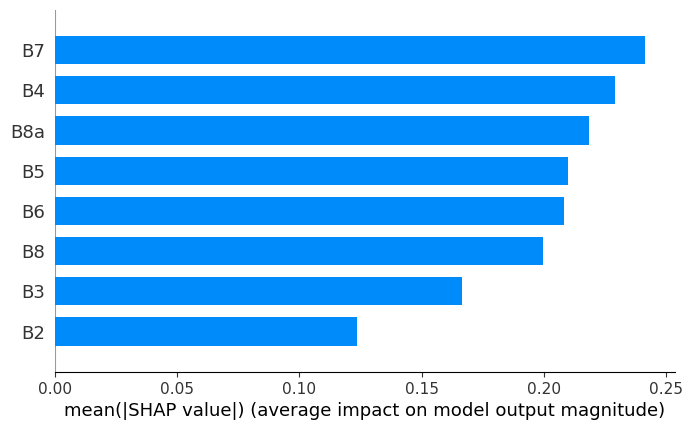

In [9]:
predict_function = lambda X: final_model.predict(X)

# Create an explainer using the Shapley sampling method
explainer = shap.Explainer(predict_function, X)

# Calculate Shapley values for every feature
shap_values = explainer(X)

# Plot summary plot for the features
shap.summary_plot(shap_values,X, plot_type="bar", feature_names=["B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a"], show=False)
    
plt.savefig("D:/Mip and TSS Project/Graphs_article_2/summary plot SHAP/MP_S2_summary_plot.png", bbox_inches='tight', dpi=600)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


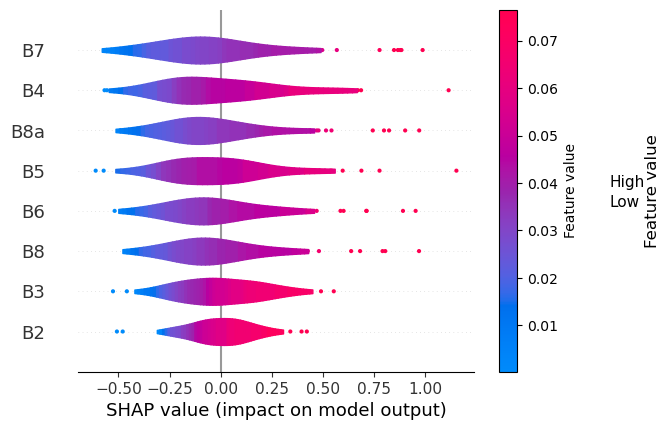

In [10]:
# Plot summary plot for the features
shap.summary_plot(shap_values,X, plot_type="violin", feature_names=["B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a"], 
                  color=plt.cm.Blues, show=False)  # Provide appropriate feature names

plt.colorbar(label='Feature value')  # Add color scale bar with label

plt.savefig("D:/Mip and TSS Project/Graphs_article_2/summary plot SHAP/MP_S2_summary_plot_violin.png", bbox_inches='tight', dpi=600)

# Show the plot
plt.show()

Vizualize the scoring for the Kfolds

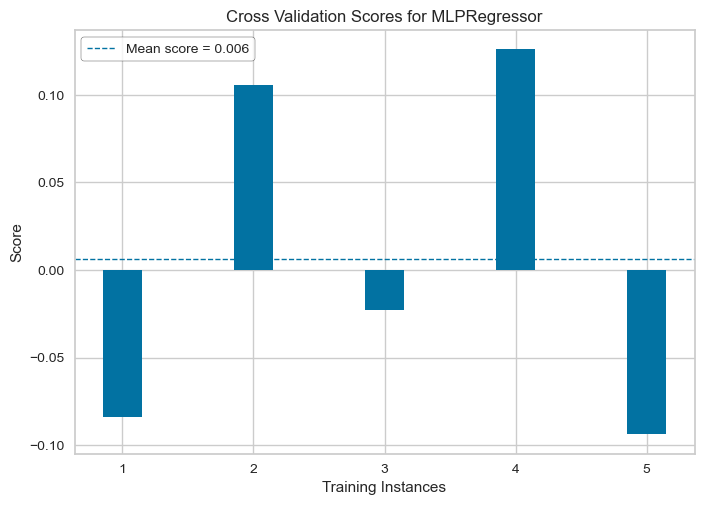

In [52]:
from yellowbrick.model_selection import cv_scores
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
visulazizer = cv_scores (final_model, X, y, cv=kfold, scoring="r2")

Split the data into training and testing and calcuate metrics for testing dataset

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2)
final_model_2=final_model.fit(X_train, y_train)
y_pred_test=final_model_2.predict (X_test)
r2_test=r2_score (y_pred_test, y_test)
rmse_test=mean_squared_error (y_pred_test, y_test, squared=False)
print (r2_test, rmse_test)


-64.50290507325506 12.692365757986376


metrics for training dataset

In [42]:
y_pred_train=final_model_2.predict (X_train)
r2_train=r2_score (y_pred_train, y_train)
rmse_train=mean_squared_error (y_pred_train, y_train, squared=False)
print (r2_train, rmse_test)

-63.31797720770683 12.692365757986376


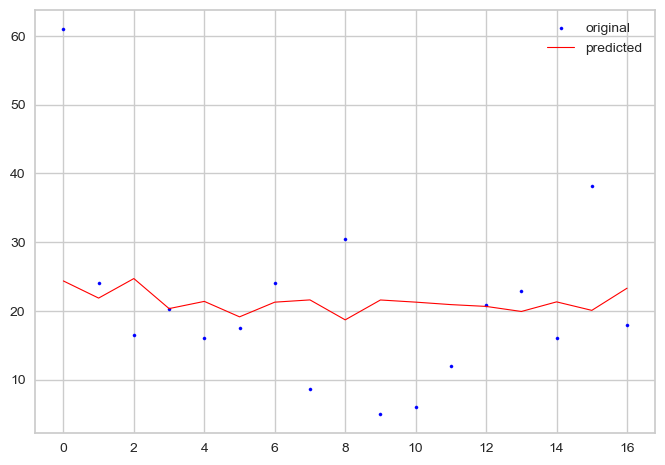

In [44]:
x_axes = range(len(y_pred_test))
plt.scatter(x_axes, y_test, s=5, color="blue", label="original")
plt.plot(x_axes, y_pred_test, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()


In [47]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [11]:
data_1=rasterio.open ("D:/Mip and TSS Project/spatiotemporal test/MP_longitudnal/Direct estimation by S2/37 TiszaroffTiszasuly/subset_17_of_subset_16_of_S2B_MSIL2A_20220623T094039_N0400_R036_T34TDT_20220623T114717_resampled_Cnv.tif")
data_2=data_1.read ()
data_3=np.swapaxes (data_2, 0, 2)
data_3=np.swapaxes (data_3, 0, 1)
data_3 = data_3.reshape (data_3.shape [0]*data_3.shape [1], data_3.shape [2])
prediction = final_model.predict (data_3)
prediction=prediction.reshape (1,data_2.shape [1] , data_2.shape [2])
prediction=prediction.astype (np.int32)
with rasterio.open ("D:/Mip and TSS Project/spatiotemporal test/MP_longitudnal/Direct estimation by S2/37 TiszaroffTiszasuly/MP_dierct_S2_subset_17_of_subset_16_of_S2B_MSIL2A_20220623T094039_N0400_R036_T34TDT_20220623T114717_resampled_Cnv.tif", 'w',
                    driver="GTiff", 
                   width=data_2.shape [2], 
                   height=data_2.shape [1],
                   count=1, 
                   crs=data_1.crs, 
                   transform=data_1.transform, 
                   dtype=rasterio.int32) as dst:
    dst.write (prediction)